In [2]:
import numpy as np
import os
from scipy.stats import norm
import math
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from pandas.tseries.offsets import DateOffset
from dateutil.relativedelta import relativedelta
from scipy.optimize import fsolve, root
import datetime
import copy
from sklearn.metrics import mean_squared_error
import matplotlib.ticker as mtick 
import statsmodels.api as sm
import seaborn as sns

In [18]:
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

## Fixed income functions

In [3]:
# curve data
os.chdir('INSERT_DATA_PATH_HERE')
EUSA = pd.read_excel('EUSA_data.xlsx')

# change dataframe layout
index = EUSA['Dates'].copy()
EUSA = pd.melt(EUSA.reset_index(),
               id_vars=['Dates'],
               value_vars=['6M', '1Y', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y', '12Y', '15Y', '20Y', '25Y', '30Y'],
               var_name='Maturity', value_name='Spot rate').set_index(['Dates'])
EUSA.name = 'EUSA'

# convert strings to float
def maturity_convert(Maturity):
    if Maturity[-1] == 'M':
        MaturityInYear = float(Maturity[:-1]) / 12  # if 6M -> 6/12
    else:
        MaturityInYear = float(Maturity[:-1])       # if xY -> float(x)
    return MaturityInYear

EUSA['Maturity (years)'] = EUSA['Maturity'].apply(lambda x: maturity_convert(x))

# change % to decimal
EUSA['Spot rate (decimal)'] = EUSA['Spot rate'].apply(lambda x: x / 100)

# cubic spline interpolation
def cubspline_curve(date, T, df_curve):
    S = interp1d(df_curve['Maturity (years)'][str(date)], 
                 df_curve['Spot rate (decimal)'][str(date)], 
                 kind='cubic', 
                 fill_value='extrapolate')
    return S(T)

def disc_factor(date, T, curve = EUSA):
    
    rate = np.log(1 + cubspline_curve(date, T, curve))

    return np.exp(-rate * T)    # curve is cont. comp.

def forw_rate(date, T, tau, curve = EUSA):

    P_0_T = disc_factor(date, T, curve)
    P_0_T_tau = disc_factor(date, T+tau, curve)

    return 1 / tau * (P_0_T / P_0_T_tau - 1)

def payment_schedule(date, expiry, tenor, tau):
    unadj_dates = []
    adj_dates = []

    t_0 = pd.Timestamp(date).date()
    t_m = (t_0 + DateOffset(months=(expiry * 12)) + pd.tseries.offsets.BusinessDay(0)).date()
    t_n = (t_m + DateOffset(months=(tenor * 12))).date()    #unadjusted for business days
    t_m_copy = t_m

    delta_months = relativedelta(months=+(tau * 12))

    while t_m_copy < t_n:
        unadj_dates.append(t_m_copy)
        t_m_copy = t_m_copy + delta_months

    unadj_dates.append(t_m_copy)

    for date in unadj_dates:
        adj_dates.append((date + pd.tseries.offsets.BusinessDay(0)).date())
    
    return adj_dates

def coverage(date, expiry, tenor, tau):
    coverage = []
    dates = []

    adj_dates = payment_schedule(date, expiry, tenor, tau)
    t_0 = pd.Timestamp(date).date()
    dates_roll = expiry + tau

    for i in range(1, len(adj_dates)):
        coverage.append(1 / 360 * (
            360 * (adj_dates[i].year - adj_dates[i - 1].year)
            + 30 * (adj_dates[i].month - adj_dates[i - 1].month)
            + min(30, adj_dates[i].day) 
            - min(30, adj_dates[i - 1].day)
            )
        )
        dates.append(dates_roll)
        dates_roll = dates_roll + coverage[i - 1]

    # coverage[0] = coverage
    # coverage[1] = tidspunkt for betaling
    return coverage, dates

def swap_rate(date, expiry, tenor, tau_floating, tau_fixed, curve = EUSA):
    floating_leg = 0
    fixed_leg = 0

    floating_coverage, floating_dates = coverage(date, expiry, tenor, tau_floating)
    fixed_coverage, fixed_dates = coverage(date, expiry, tenor, tau_fixed)

    for i in range(len(floating_dates)):
        floating_leg = floating_leg + disc_factor(date, floating_dates[i], curve) * floating_coverage[i] * forw_rate(date, floating_dates[i] - floating_coverage[i], floating_coverage[i],  curve)

    for i in range(len(fixed_dates)):
        fixed_leg = fixed_leg + disc_factor(date, fixed_dates[i]) * fixed_coverage[i]

    return floating_leg / fixed_leg

def annuity_func(date, expiry, tenor, tau, curve = EUSA):
    ann = 0
    cov, dates = coverage(date, expiry, tenor, tau)
    for i in range(len(dates)):
        ann = ann + disc_factor(date, dates[i], curve) * cov[i]
    return ann

def bachelier(F, K, sigma_normal, date, expiry, tenor, tau, t = 0):
    d = (F - K) / (sigma_normal * np.sqrt(expiry - t))
    return annuity_func(date, expiry, tenor, tau) * ((F - K) * norm.cdf(d) + sigma_normal * np.sqrt(expiry - t) * norm.pdf(d))

## Payer swaption functions

In [4]:
def trap_integration(xmin, xmax, N):
    # Computes integration points and weights for trapezoid scheme
    # integrates from xmin to xmax with N integration points
    uv = np.linspace(xmin, xmax, N)
    wgtv = np.ones(N)
    wgtv[[0, N - 1]] = 1 / 2
    wgtv = wgtv * (xmax - xmin) / (N - 1)
    return uv, wgtv

def char_func(u, T, theta, eta, z_0, lambd, b):
    v = 1/2 * (lambd * b)**2 * u * (u - 1)

    gamma = np.sqrt(theta**2 - 2 * eta**2 * v)
    A = 1 / eta**2 * theta * z_0 * (2 * np.log(2 * gamma / (theta + gamma - np.exp(-gamma * T)*(theta - gamma))) + (theta - gamma) * T)
    B = 2 * v * (1 - np.exp(-gamma * T)) / ((theta + gamma) * (1 - np.exp(-gamma * T)) + 2 * gamma * np.exp(-gamma * T))
    return np.exp(A + B * z_0)

def payer_price_SV(S, K, L, theta, eta, lambd, b, z_0, date, expiry, tenor):
    xmin = 0
    xmax = 2000
    int_points = 10000
    [u, wgt] = trap_integration(xmin, xmax, int_points)
    
    S_prime = b * S + (1 - b) * L
    K_prime = b * K + (1 - b) * L

    integrand = np.real((np.exp(-(1/2 + 1j * u) * np.log(K_prime / S_prime)) * char_func(1/2 + 1j * u, expiry, theta, eta, z_0, lambd, b)) / (u**2 + 1/4))
    integral = sum(wgt * integrand)

    annuity = annuity_func(date, expiry, tenor, tau_floating_leg, EUSA)

    return annuity / b * (S_prime - K_prime / np.pi * integral)

## Misc inputs

In [34]:
###############################
date = datetime.date(2023,9,18)
###############################

tau_floating = 0.5      # EUSA swaps are semi-annual
tau_floating_leg = 0.5
tau_fixed = 1           # fixed rates paid annually

z_0 = 1

## Load data

In [6]:
swaption_data = pd.read_excel('swaption_cube_23_bermudan.xlsx')
number_of_grids = len(pd.ExcelFile('swaption_cube_23_bermudan.xlsx').sheet_names) / 2
xl_names = pd.ExcelFile('swaption_cube_23_bermudan.xlsx').sheet_names[:int(number_of_grids)]

df_swaption_iv = []

for i in range(int(number_of_grids)):
    grid_i = pd.read_excel('swaption_cube_23_bermudan.xlsx', sheet_name=(i), index_col = 0)
    grid_i.name = grid_i.index.name
    df_swaption_iv.append(grid_i)

# the swaption_iv holds the swaption grid for different strikes
# its dimensions are (m, n, #number of strikes)
# the calibration will be done for each (m, n)-pair with weights assigned for each strike
# access the grids by swaption_iv[i]
# access grid-points by swaption_iv[i].iloc[j,k]

In [7]:
swaption_data = pd.read_excel('swaption_cube_23_bermudan.xlsx')
number_of_grids = len(pd.ExcelFile('swaption_cube_23_bermudan.xlsx').sheet_names) / 2
xl_names = pd.ExcelFile('swaption_cube_23_bermudan.xlsx').sheet_names[int(number_of_grids):]

df_swaption_strikes = []

for i in range(int(number_of_grids),2*int(number_of_grids)):
    grid_i = pd.read_excel('swaption_cube_23_bermudan.xlsx', sheet_name=(i), index_col = 0)
    grid_i.name = grid_i.index.name
    df_swaption_strikes.append(grid_i)

# the swaption_iv holds the swaption grid for different strikes
# its dimensions are (m, n, #number of strikes)
# the calibration will be done for each (m, n)-pair with weights assigned for each strike
# access the grids by swaption_iv[i]
# access grid-points by swaption_iv[i].iloc[j,k]

## Set up lists with strikes, swap rates, and prices

In [9]:
swaption_expiry = np.array([1/12, 3/12, 6/12, 9/12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 30])
swaption_tenor = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 30])

df_strike = []
df_swap_rate = []
df_price = []

for i in range(len(df_swaption_iv)): # grid loop
    [M,N] = df_swaption_iv[i].shape

    df_strike_i = df_swaption_iv[i].copy()
    df_swap_rate_i = df_swaption_iv[i].copy()
    df_price_i = df_swaption_iv[i].copy()

    for m in range(M): # expiry loop
        T = swaption_expiry[m]      

        for n in range(N): # tenor loop
            tenor = swaption_tenor[n]
            moneyness = float(df_swaption_strikes[i].name) / 10000  # convert from bps. to decimal

            K = df_swaption_strikes[i].iloc[m,n] / 100
            S = K - moneyness

            normal_vol = df_swaption_iv[i].iloc[m,n] / 10000   # convert from bps. to decimal
            
            df_strike_i.iloc[m,n] = K
            df_swap_rate_i.iloc[m,n] = S
            df_price_i.iloc[m,n] = bachelier(S, K, normal_vol, datetime.date(2023, 9, 18), T, tenor, tau_floating, t = 0)  # bachelier price (since data uses normal vols)
    
    df_strike.append(pd.DataFrame(df_strike_i))
    df_swap_rate.append(pd.DataFrame(df_swap_rate_i))
    df_price.append(pd.DataFrame(df_price_i))

df_strike, df_swap_rate, df_price

([         1Yr     2Yr     3Yr     4Yr     5Yr     6Yr     7Yr     8Yr     9Yr  \
  200                                                                            
  1Mo   0.0614  0.0580  0.0556  0.0541  0.0533  0.0528  0.0525  0.0524  0.0523   
  3Mo   0.0608  0.0572  0.0550  0.0537  0.0529  0.0525  0.0523  0.0522  0.0521   
  6Mo   0.0588  0.0555  0.0537  0.0527  0.0522  0.0519  0.0518  0.0517  0.0518   
  9Mo   0.0570  0.0542  0.0528  0.0520  0.0516  0.0515  0.0514  0.0514  0.0515   
  1Yr   0.0550  0.0528  0.0518  0.0512  0.0510  0.0510  0.0510  0.0511  0.0513   
  2Yr   0.0506  0.0501  0.0499  0.0499  0.0501  0.0502  0.0504  0.0507  0.0509   
  3Yr   0.0495  0.0496  0.0497  0.0500  0.0502  0.0504  0.0507  0.0510  0.0512   
  4Yr   0.0496  0.0498  0.0501  0.0503  0.0506  0.0510  0.0512  0.0514  0.0515   
  5Yr   0.0500  0.0504  0.0506  0.0508  0.0513  0.0515  0.0517  0.0518  0.0519   
  6Yr   0.0508  0.0509  0.0511  0.0516  0.0518  0.0520  0.0521  0.0522  0.0522   
  7Yr   0.0510  

# 15nc1 Bermudan
###  Coterminal market strip

In [10]:
swaption_expiry = np.array(["1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "11Yr", "12Yr", "13Yr", "14Yr"])
swaption_tenor  = np.array(["1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "11Yr", "12Yr", "13Yr", "14Yr"])

strike_strip = []
swaprate_strip = []
price_strip = []

for i in range(len(df_strike)):

    swaprate_strip_i = df_strike[0].loc["1Yr":"14Yr","1Yr"].copy()
    price_strip_i = df_strike[0].loc["1Yr":"14Yr","1Yr"].copy()
    strike_strip_i = df_strike[0].loc["1Yr":"14Yr","1Yr"].copy()

    for n in range(len(swaption_tenor)):

        expiry = swaption_expiry[n]     # forward loop from start
        tenor = swaption_tenor[-1-n]    # backward loop from end

        strike_strip_i[n] = df_strike[i].loc[expiry, tenor]
        swaprate_strip_i[n] = df_swap_rate[i].loc[expiry, tenor]
        price_strip_i[n] = df_price[i].loc[expiry, tenor]

    strike_strip.append(strike_strip_i)
    swaprate_strip.append(swaprate_strip_i)
    price_strip.append(price_strip_i)

### Calibration 1

In [ ]:
expiry = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14])
tenors = np.array([14,13,12,11,10,9,8,7,6,5,4,3,2,1])

def pricing_fixed(lambd, b, eta, theta):

    M = len(expiry)
    prices = copy.deepcopy(price_strip)
    
    print("lambda =", lambd, "b =", b, "eta =", eta, "theta =", theta)
    for m in range(M):  # option expiry
        T = expiry[m]
        tenor = tenors[m]

        for i in range(len(strike_strip)): # strike level
            
            K = strike_strip[i][m]
            S = swaprate_strip[i][m]

            model_price = payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor)
            prices[i][m] = model_price

    return prices

# moneyness            +200  +100  +50  +25   ATM  -25   -50  -100  -200
weightings = np.array([0.05, 0.05, 0.1, 0.15, 0.3, 0.15, 0.1, 0.05, 0.05])

weights = copy.deepcopy(price_strip)
for n in range(len(weightings)):
    weights[n].iloc[:] = weightings[n]

bounds = ((1e-8, np.inf),(1e-8, np.inf),(1e-8, np.inf),(0.27, np.inf))

init_lambd = 0.25
init_b = 0.2
init_eta = 1.0
init_theta = 0.3
initguess = [init_lambd, init_b, init_eta, init_theta]

def Err(x):
    lambd, b, eta, theta = x
    err = np.sum(weights * (np.array(pricing_fixed(lambd, b, eta, theta)) - np.array(price_strip))**2)
    print("objective function =", err)
    return err

res = opt.minimize(Err, initguess, bounds = bounds, tol = 1e-12)
lambd, b, eta, theta = res.x

In [ ]:
b =	0.28552126359807395
eta = 1.5127555766521044
theta = 0.27000001
lambd = 0.30935653650722994

In [ ]:
expiry = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14])
tenors = np.array([14,13,12,11,10,9,8,7,6,5,4,3,2,1])

# check 3y12y, 6y9y, 9y6y, 12y3
points = [2,5,8,11]

IV_1 = []

for i in range(len(points)):

    S = swaprate_strip[4][points[i]]

    strikes = np.linspace(S -200/10000, S + 200/10000, 49)
    IV_index = np.round(np.linspace(-200, 200, len(strikes)),2)

    IV_i = pd.Series(np.zeros(len(strikes)),
                     index = IV_index)

    T = expiry[points[i]]
    tenor = tenors[points[i]]
    print("T = ", T, "tenor = ", tenor)

    for n in range(len(strikes)):

        K = strikes[n]
    
        def Root_Solving(x):
            return bachelier(S, K, x, date, T, tenor, tau_floating, t = 0) - payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor)

        res = fsolve(Root_Solving, 0.01)

        IV_i.iloc[n] = res * 10000   # convert to bp
        print(IV_i.iloc[n])

    IV_1.append(IV_i)

### Calibration 2

In [ ]:
expiry = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14])
tenors = np.array([14,13,12,11,10,9,8,7,6,5,4,3,2,1])

def pricing_lambd(b, eta, theta, lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9, lambda_10, lambda_11, lambda_12, lambda_13, lambda_14):

    lambdas = np.array([lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9, lambda_10, lambda_11, lambda_12, lambda_13, lambda_14])

    M = len(expiry)
    prices = copy.deepcopy(price_strip)
    
    for m in range(M):  # option expiry
        T = expiry[m]
        tenor = tenors[m]
        lambd = lambdas[m]

        print("b =", b, "eta = ", eta, "theta =", theta, "lambda =", lambd)
        for i in range(len(strike_strip)): # strike level
            
            K = strike_strip[i][m]
            S = swaprate_strip[i][m]

            model_price = payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor)
            prices[i][m] = model_price

    return prices

# moneyness            +200  +100  +50  +25   ATM  -25   -50  -100  -200
weightings = np.array([0.05, 0.05, 0.1, 0.15, 0.3, 0.15, 0.1, 0.05, 0.05])

weights = copy.deepcopy(price_strip)
for n in range(len(weightings)):
    weights[n].iloc[:] = weightings[n]

bounds = ((1e-8, np.inf),(1e-8, np.inf),(0.379404708181496, 0.379404708181496),
          (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), 
          (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf))

init_b = 0.15
init_eta = 1.5
init_theta = 0.40
init_lambda_1 = 0.3
init_lambda_2 = 0.3
init_lambda_3 = 0.3
init_lambda_4 = 0.3
init_lambda_5 = 0.3
init_lambda_6 = 0.3
init_lambda_7 = 0.3
init_lambda_8 = 0.3
init_lambda_9 = 0.3
init_lambda_10 = 0.3
init_lambda_11 = 0.3
init_lambda_12 = 0.3
init_lambda_13 = 0.3
init_lambda_14 = 0.3
initguess = [init_b, init_eta, init_theta,
             init_lambda_1, init_lambda_2, init_lambda_3, init_lambda_4, init_lambda_5, init_lambda_6, init_lambda_7, init_lambda_8, init_lambda_9, init_lambda_10, init_lambda_11, init_lambda_12, init_lambda_13, init_lambda_14]

def Err(x):
    b, eta, theta, lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9, lambda_10, lambda_11, lambda_12, lambda_13, lambda_14 = x
    err = np.sum(weights * (np.array(pricing_lambd(b, eta, theta, lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9, lambda_10, lambda_11, lambda_12, lambda_13, lambda_14))
                            -np.array(price_strip))**2)
    print("Objective function =", err)
    return err

res = opt.minimize(Err, initguess, bounds = bounds, tol = 1e-12)
b, eta, theta, lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9, lambda_10, lambda_11, lambda_12, lambda_13, lambda_14 = res.x
lambdas = pd.Series(data = np.array([lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9, lambda_10, lambda_11, lambda_12, lambda_13, lambda_14]), 
                    index = ["1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "11Yr", "12Yr","13Yr","14Yr"])

In [ ]:
b =	0.20342584463050495
eta = 1.4714888854480443
theta = 0.379404708181496
lambdas = pd.Series(data = np.array([0.31019157, 0.32745481, 0.32667033, 0.31896721, 0.30683361, 0.29715606, 0.28673488, 0.27939385, 0.27297822, 0.26892379, 0.26938024, 0.26940732, 0.27254794, 0.26907595]), 
                    index = ["1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "11Yr", "12Yr","13Yr","14Yr"])

In [ ]:
expiry = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14])
tenors = np.array([14,13,12,11,10,9,8,7,6,5,4,3,2,1])

# check 3y12y, 6y9y, 9y6y, 12y3
points = [2,5,8,11]

IV_2 = []

for i in range(len(points)):
    lambd = lambdas[points[i]]

    S = swaprate_strip[4][points[i]]

    strikes = np.linspace(S -200/10000, S + 200/10000, 49)
    IV_index = np.round(np.linspace(-200, 200, len(strikes)),2)

    IV_i = pd.Series(np.zeros(len(strikes)),
                     index = IV_index)
  
    T = expiry[points[i]]
    tenor = tenors[points[i]]
    print("T = ", T, "tenor = ", tenor)

    for n in range(len(strikes)):

        K = strikes[n]    
        def Root_Solving(x):
            return bachelier(S, K, x, date, T, tenor, tau_floating, t = 0) - payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor)
        res = fsolve(Root_Solving, 0.01)

        IV_i.iloc[n] = res * 10000   # convert to bp
        print(IV_i.iloc[n])
    IV_2.append(IV_i)

### Calibration 3

In [ ]:
expiry = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14])
tenors = np.array([14,13,12,11,10,9,8,7,6,5,4,3,2,1])

# moneyness         +200  +100  +50  +25   ATM  -25   -50  -100  -200
weights = np.array([0.05, 0.05, 0.1, 0.15, 0.3, 0.15, 0.1, 0.05, 0.05])

lambd_calibrated = price_strip[0].copy()
b_calibrated = price_strip[0].copy()
eta_calibrated = price_strip[0].copy()
model_prices = price_strip[0].copy()

theta = 0.379404708181496
M = len(expiry)

for m in range(M):  # calibrate swaption m
    T = expiry[m]
    tenor = tenors[m]
    print("Expiry = ", T, "Tenor = ", tenor)

    strikes_i = []
    swap_rate_i = []
    market_price_i = []

    for i in range(len(strike_strip)): # strikes loop

        strikes_i.append(strike_strip[i].iloc[m])
        swap_rate_i.append(swaprate_strip[i].iloc[m])
        market_price_i.append(price_strip[i].iloc[m])

    for p in range(1):  # calibrate (m,n)-swaption
        strikes = np.array(strikes_i)
        obs_prices = np.array(market_price_i)
        obs_swap_rates = np.array(swap_rate_i)

        bounds = ((1e-8, np.inf),(1e-8, np.inf),(1e-8, np.inf))

        init_lambd = 0.5
        init_b = 0.50
        init_eta = 0.50
        initguess = [init_lambd, init_b, init_eta]

        def Err(x):
            lambd, b, eta = x

            price_hat = []

            for i in range(len(strike_strip)):
                
                price_hat.append(payer_price_SV(obs_swap_rates[i], strikes[i], obs_swap_rates[i], theta, eta, lambd, b, z_0, date, T, tenor))

            price_hat = np.array(price_hat)
            err = np.sum(weights * (price_hat - obs_prices)**2)

            return err

    res = opt.minimize(Err, initguess, bounds = bounds, tol = 1e-14)
    lambd, b, eta = res.x

    lambd_calibrated[m] = lambd
    b_calibrated[m] = b
    eta_calibrated[m] = eta

    print('\n', "observed ATM price = ", market_price_i[4]) # market price
    print('\n', "calibrated ATM price = ", payer_price_SV(obs_swap_rates[4], strikes[4], obs_swap_rates[4], theta, eta, lambd, b, z_0, date, T, tenor))
    print('\n', 'calibrated lambda', lambd)
    print('\n', 'calibrated b', b)
    print('\n', 'calibrated eta', eta)

In [ ]:
theta = 0.379404708181496

lambd_calibrated = np.array([0.31252499, 0.32716261, 0.32804561, 0.31906521, 0.30234794, 0.29556366, 0.28708199, 0.28092718, 0.27477928, 0.2700827, 0.27082702, 0.27060634, 0.27382635, 0.27106085])
b_calibrated = np.array([0.20914441, 0.21395428, 0.20897396, 0.2004646 , 0.19038863, 0.19244539, 0.19595601, 0.19932191, 0.20335474, 0.20738039, 0.23204294, 0.23611073, 0.2660578 , 0.28114119])
eta_calibrated = np.array([1.57820697, 1.46156327, 1.5123661 , 1.47471207, 1.32609028, 1.41845365, 1.48493632, 1.53012501, 1.54337588, 1.51934625, 1.52744571, 1.51632786, 1.50961771, 1.5378323])

In [ ]:
expiry = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14])
tenors = np.array([14,13,12,11,10,9,8,7,6,5,4,3,2,1])

# check 3y12y, 6y9y, 9y6y, 12y3
points = [2,5,8,11]

IV_3 = []

for i in range(len(points)):
    lambd = lambd_calibrated[points[i]]
    eta = eta_calibrated[points[i]]
    b = b_calibrated[points[i]]

    S = swaprate_strip[4][points[i]]

    strikes = np.linspace(S -200/10000, S + 200/10000, 49)
    IV_index = np.round(np.linspace(-200, 200, len(strikes)),2)

    IV_i = pd.Series(np.zeros(len(strikes)),
                     index = IV_index)
  
    T = expiry[points[i]]
    tenor = tenors[points[i]]
    print("T = ", T, "tenor = ", tenor)

    for n in range(len(strikes)):

        K = strikes[n]    
        def Root_Solving(x):
            return bachelier(S, K, x, date, T, tenor, tau_floating, t = 0) - payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor)
        res = fsolve(Root_Solving, 0.01)

        IV_i.iloc[n] = res * 10000   # convert to bp
        print(IV_i.iloc[n])
        
    IV_3.append(IV_i)

### Check their fit

In [ ]:
# latex_width = 6.69423 inches
w = 6.69423
golden_ratio = (5**.5 - 1) / 2
h = w * 1.3 * golden_ratio

In [ ]:
expiries = ["3Yr","6Yr","9Yr","12Yr"]
tenors = ["12Yr","9Yr","6Yr","3Yr"]
strike_index = np.array([200, 100, 50, 25, 0, -25, -50, -100, -200])

iv_smiles = []

for i in range(len(expiries)):
    expiry = expiries[i]
    tenor = tenors[i]
    smile_i = pd.Series([df_swaption_iv[0].loc[expiry, tenor], df_swaption_iv[1].loc[expiry,tenor], df_swaption_iv[2].loc[expiry,tenor], df_swaption_iv[3].loc[expiry,tenor], 
                         df_swaption_iv[4].loc[expiry,tenor], # ATM
                         df_swaption_iv[5].loc[expiry,tenor], df_swaption_iv[6].loc[expiry,tenor], df_swaption_iv[7].loc[expiry,tenor], df_swaption_iv[8].loc[expiry,tenor]],
                         index = strike_index)
    iv_smiles.append(smile_i)

fig, ax = plt.subplots(2, 2, figsize=(w,h))

ax[0, 0].plot(iv_smiles[0].index, iv_smiles[0], label = 'Market', color = 'r')
ax[0, 0].plot(IV_1[0].index, IV_1[0], label = 'Calibration 1', color = '#ff7f0e')
ax[0, 0].plot(IV_2[0].index, IV_2[0], label = 'Calibration 2', color = 'g')
ax[0, 0].plot(IV_3[0].index, IV_3[0], label = 'Calibration 3', color = 'b')
ax[0, 0].set_title('3y12y swaption')
ax[0, 0].set_ylim(84,112)
ax[0, 0].set_yticks(np.arange(84,119,7))
ax[0, 0].set_xlim(min(IV_index), max(IV_index))
ax[0, 0].set_xlabel('Moneyness (bp)')
ax[0, 0].grid(ls = (0,(1,2)))
ax[0, 0].legend(frameon=False, loc = 'upper left', fontsize=8)

ax[0, 1].plot(iv_smiles[1].index, iv_smiles[1], label = 'Market', color = 'r')
ax[0, 1].plot(IV_1[1].index, IV_1[1], label = 'Calibration 1', color = '#ff7f0e')
ax[0, 1].plot(IV_2[1].index, IV_2[1], label = 'Calibration 2', color = 'g')
ax[0, 1].plot(IV_3[1].index, IV_3[1], label = 'Calibration 3', color = 'b')
ax[0, 1].set_title('6y9y swaption')
ax[0, 1].set_ylim(84,102)
ax[0, 1].set_yticks(np.arange(84,108,6))
ax[0, 1].set_xlim(min(IV_index), max(IV_index))
ax[0, 1].set_xlabel('Moneyness (bp)')
ax[0, 1].grid(ls = (0,(1,2)))
ax[0, 1].legend(frameon=False, loc = 'upper left', fontsize=8)

ax[1, 0].plot(iv_smiles[2].index, iv_smiles[2], label = 'Market', color = 'r')
ax[1, 0].plot(IV_1[2].index, IV_1[2], label = 'Calibration 1', color = '#ff7f0e')
ax[1, 0].plot(IV_2[2].index, IV_2[2], label = 'Calibration 2', color = 'g')
ax[1, 0].plot(IV_3[2].index, IV_3[2], label = 'Calibration 3', color = 'b')
ax[1, 0].set_title('9y6y swaption')
ax[1, 0].set_ylim(75,105)
ax[1, 0].set_yticks(np.arange(75,115,10))
ax[1, 0].set_xlim(min(IV_index), max(IV_index))
ax[1, 0].set_xlabel('Moneyness (bp)')
ax[1, 0].grid(ls = (0,(1,2)))
ax[1, 0].legend(frameon=False, loc = 'upper left',fontsize=8)

ax[1, 1].plot(iv_smiles[3].index, iv_smiles[3], label = 'Market', color = 'r')
ax[1, 1].plot(IV_1[3].index, IV_1[3], label = 'Calibration 1', color = '#ff7f0e')
ax[1, 1].plot(IV_2[3].index, IV_2[3], label = 'Calibration 2', color = 'g')
ax[1, 1].plot(IV_3[3].index, IV_3[3], label = 'Calibration 3', color = 'b')
ax[1, 1].set_title('12y3 swaption')
ax[1, 1].set_ylim(75,105)
ax[1, 1].set_yticks(np.arange(75,115,10))
ax[1, 1].set_xlim(min(IV_index), max(IV_index))
ax[1, 1].set_xlabel('Moneyness (bp)')
ax[1, 1].grid(ls = (0,(1,2)))
ax[1, 1].legend(frameon=False, fontsize=8)

fig.tight_layout()
plt.savefig('C:/Users/Mikkel/OneDrive/CBS/CBS - FIN/THESIS/Main/python/billeder/iv_smiles_15nc1.pgf')

## Bermudan functions

In [11]:
def create_cubic_curve_cc(t, T, tau, date, curve_data): # returns cubic spline interpolated curve in cont. comp. rates
    ts = pd.Series(np.arange(t, T+tau, tau))
    curve = ts.copy()

    for i in range(len(ts)):
        tt = ts.iloc[i]
        curve.iloc[i] = np.log(1 + cubspline_curve(date, tt, curve_data))

    samlet = pd.DataFrame(curve, columns =['Rate']).set_index(ts.values)
    samlet.index.name = 'T'

    return samlet

def trap_integration(xmin, xmax, N):
    # Computes integration points and weights for trapezoid scheme
    # integrates from xmin to xmax with N integration points
    uv = np.linspace(xmin, xmax, N)
    wgtv = np.ones(N)
    wgtv[[0, N - 1]] = 1 / 2
    wgtv = wgtv * (xmax - xmin) / (N - 1)
    return uv, wgtv

def bond_func(cubic_curve, t, T, x, y, kappa):

    P_0_T = np.exp(-cubic_curve.loc[T].values.T * T)                        # convert rate_T to P(0,T)
    P_0_t = np.exp(-cubic_curve.loc[t].values.T * t)                        # convert rate_t to P(0,t)
    G_t_T = (1 - np.exp(-kappa * (T - t))) / kappa                          # assume kappa(t)=kappa (constant kappa over each period)

    return P_0_T / P_0_t * np.exp(-G_t_T * x - 1/2 * G_t_T**2 * y)

def partial_S_x(t, x, y, S, kappa, expiry, tenor, cubic_curve):
    G_t_T0 = (1 - np.exp(-kappa * (expiry - t))) / kappa
    G_t_TN = (1 - np.exp(-kappa * (expiry + tenor - t))) / kappa 
    P_t_T0 = bond_func(cubic_curve, t, expiry, x, y, kappa)
    P_t_TN = bond_func(cubic_curve, t, expiry + tenor, x, y, kappa)

    ann = 0
    sum = 0
    for i in range(tenor):
        ann += bond_func(cubic_curve, t, expiry + i + 1, x, y, kappa)
        sum += ((1 - np.exp(-kappa * (expiry + i + 1 - t))) / kappa) * bond_func(cubic_curve, t, expiry + i + 1, x, y, kappa)

    S_t = (P_t_T0 - P_t_TN) / ann

    return -(G_t_T0 * P_t_T0 - G_t_TN * P_t_TN) / ann + S_t / ann * sum

def model_sim(kappa, theta, dt, paths, lambds, etas, bs, swaprate_strip, cubic_curve):

    # -------------------
    np.random.seed(54321)
    # -------------------

    sim_horizon = len(lambds)+1

    steps = sim_horizon * 252
    numb_sims = steps + 1

    size = (numb_sims, paths)
    x = np.zeros(size)
    y = np.zeros(size)
    z = np.zeros(size)

    mean = np.array([0,0])
    cov = np.array([[1,0],
                    [0,1]])

    z_0 = 1
    x_t = 0
    y_t = 0

    z_t = z_0
    Z_t = z_0

    x[0,:] = x_t
    y[0,:] = y_t
    z[0,:] = z_t

    zeros = np.zeros(len(x.T))

    lambds = np.append(lambds, lambds[-1])
    etas = np.append(etas, etas[-1])
    bs = np.append(bs, bs[-1])
    swaprate_strip = np.append(swaprate_strip, swaprate_strip[-1])

    for i in range(sim_horizon):

        lambd = lambds[i]
        b = bs[i]
        eta = etas[i]
        S_0 = swaprate_strip[i]

        sigma_r = lambd * (S_0 + b * partial_S_x(i+1,0,0, S_0, kappa, i+1, sim_horizon-i, cubic_curve) * x_t)

        for t in range(252):

            W_t = np.transpose(np.random.multivariate_normal(mean, cov, size = paths) * np.sqrt(dt))

            z_t = z_t + theta * (z_0 - Z_t) * dt + eta * np.sqrt(Z_t) * W_t[1,:] 
            Z_t = np.maximum(zeros, z_t)

            y_t = y_t + (Z_t * sigma_r**2 - 2 * kappa * y_t) * dt
            x_t = x_t + (y_t - kappa * x_t) * dt + np.sqrt(Z_t) * sigma_r * W_t[0,:]

            x[1 + i*252 + t,:] = x_t
            y[1 + i*252 + t,:] = y_t
            z[1 + i*252 + t,:] = z_t
    return x, y, z

def bermudan_price(K, kappa, theta, dt, paths, lambds, etas, bs, swaprate_strip, cubic_curve):

    # -------------------
    np.random.seed(54321)
    # -------------------

    sim_horizon = len(lambds)+1 

    steps = sim_horizon * 252
    numb_sims = steps + 1

    size = (numb_sims, paths)
    x = np.zeros(size)
    y = np.zeros(size)
    z = np.zeros(size)

    mean = np.array([0,0])
    cov = np.array([[1,0],
                    [0,1]])

    z_0 = 1
    x_t = 0
    y_t = 0

    z_t = z_0
    Z_t = z_0

    x[0,:] = x_t
    y[0,:] = y_t
    z[0,:] = z_t

    zeros = np.zeros(len(x.T))

    lambds = np.append(lambds, lambds[-1])
    etas = np.append(etas, etas[-1])
    bs = np.append(bs, bs[-1])
    swaprate_strip = np.append(swaprate_strip, swaprate_strip[-1])

    for i in range(sim_horizon):

        lambd = lambds[i]
        b = bs[i]
        eta = etas[i]
        S_0 = swaprate_strip[i]

        sigma_r = lambd * (S_0 + b * partial_S_x(i+1,0,0, S_0, kappa, i+1, sim_horizon-i, cubic_curve) * x_t)

        for t in range(252):

            W_t = np.transpose(np.random.multivariate_normal(mean, cov, size = paths) * np.sqrt(dt))

            z_t = Z_t + theta * (z_0 - Z_t) * dt + eta * np.sqrt(Z_t) * W_t[1,:] 
            Z_t = np.maximum(zeros, z_t)

            y_t = y_t + (Z_t * sigma_r**2 - 2 * kappa * y_t) * dt
            x_t = x_t + (y_t - kappa * x_t) * dt + np.sqrt(Z_t) * sigma_r * W_t[0,:]

            x[1 + i*252 + t,:] = x_t
            y[1 + i*252 + t,:] = y_t
            z[1 + i*252 + t,:] = z_t

    year_frac = np.round(np.linspace(dt, sim_horizon, sim_horizon * int(1/dt)),12)
    year_frac = np.append(0,year_frac)

    exercise_dates = np.arange(1,sim_horizon,1)
    df_x = pd.DataFrame(x).set_index(year_frac)
    df_y = pd.DataFrame(y).set_index(year_frac)
    df_z = pd.DataFrame(z).set_index(year_frac)

    x_exercise = np.where(df_x.index.isin(exercise_dates))
    y_exercise = np.where(df_y.index.isin(exercise_dates))
    z_exercise = np.where(df_z.index.isin(exercise_dates))

    df_x = np.array(df_x)
    df_y = np.array(df_y)
    df_z = np.array(df_z)

    x_berm = df_x[x_exercise]
    y_berm = df_y[y_exercise]
    z_berm = df_z[z_exercise]

    swap_rates = np.zeros(x_berm.shape)

    swap_rates = []
    annuities = []
    annuities_misc = []

    # calculate swap rates
    for i in range(sim_horizon-1):

        tenor = len(x_berm[i:])
        ann_len = sim_horizon - 1 - len(x_berm[i:])
        annuity = 0
        
        # annuities for swap rate
        for n in range(sim_horizon - 1, ann_len,-1):
            
            if n == ann_len + 1:
                P_t_Tn = bond_func(cubic_swap_curve, n, sim_horizon, x_berm[n-1], y_berm[n-1], kappa)
                annuity += P_t_Tn

            if n != ann_len + 1:
                annuity += bond_func(cubic_swap_curve, n, sim_horizon, x_berm[n-1], y_berm[n-1], kappa)
        
        swap_rate = (1 - P_t_Tn) / annuity
        swap_rates.append(swap_rate)
        annuities.append(annuity)

        # annuities for discounting
        annuity_disc = bond_func(cubic_swap_curve, i+1, i+2, x_berm[i], y_berm[i], kappa)    # period = 1, so the annuity is just a single discount factor
        annuities_misc.append(annuity_disc)

    swap_rates_berm = np.array(swap_rates)

    annuities_berm = np.array(annuities)
    annuities_berm_disc = np.array(annuities_misc)      # annuities for single-period discounting

    payer_payoff = annuities_berm * np.maximum(swap_rates_berm - K, 0) 

    swaption_val = np.zeros_like(payer_payoff)          # matrix for option values
    swaption_val[-1,:] = payer_payoff[-1,:]             # payoff in final row

    # european benchmark
    european = swaption_val[-1,:]

    # LSM algorithm
    for t in range(sim_horizon - 3, -1, -1):  # backwards loop from end (total number of loops = sim_horizon - 2 since we have value at sim_horizon - 1 from payoff)

        ITM = payer_payoff[t,:].nonzero()       # paths that are ITM at time t
        OTM = np.where(payer_payoff[t,:] == 0)  # paths that are OTM at time t

        df = annuities_berm_disc[t+1,:]         # discount factor A_(t_i-1,t_i)

        european = european * df                # european is never exercised (i.e., just discounted period-wise)

        swaption_val[t,:][OTM] = swaption_val[t+1,:][OTM] * df[OTM]  # Option value at time t, if swaption is OTM   # if OTM we will hold (exercise value = 0)

        Y = swaption_val[t+1,:][ITM] * df[ITM]  # discounted realized cash flow from continuation at time t+1

        # X inputs in basis fuctions
        St = swap_rates_berm[t,:][ITM]      
        xt = x_berm[t,:][ITM]
        yt = x_berm[t,:][ITM]
        zt = z_berm[t,:][ITM] 

        X = np.array(list(map(lambda func: func(x_t=xt, y_t=yt, z_t=zt), funcset))).T    # map values into the basis functions

        # cross-sectional regression
        reg = sm.OLS(Y, X).fit()

        # evaluate regression at each loop (Continuation value)
        ContValue = reg.fittedvalues  

        swaption_val[t,:][ITM] = np.where(payer_payoff[t,:][ITM] > ContValue,  # is immediate exercise > than continuation?
                                        payer_payoff[t,:][ITM], swaption_val[t+1,:][ITM] * df[ITM])  # True = exercise, False = discounted continuation value


    bermudan_t_0 = np.mean(swaption_val[0,:] * annuities_berm_disc[0,:])
    european_t_0 = np.mean(european * annuities_berm_disc[0,:])    

    return bermudan_t_0, european_t_0

date = datetime.date(2023,9,18)
cubic_swap_curve = create_cubic_curve_cc(0, 30, 0.25, date, EUSA)

In [12]:
# basis functions
constFunc           = lambda *args, **kwargs            : np.ones_like(kwargs['x_t'])

x_func              = lambda x_t, *args, **kwargs       : x_t
x_func_squared      = lambda x_t, *args, **kwargs       : x_t**2
x_func_cubed        = lambda x_t, *args, **kwargs       : x_t**3

y_func              = lambda y_t, *args, **kwargs       : y_t
y_func_squared      = lambda y_t, *args, **kwargs       : y_t**2
y_func_cubed        = lambda y_t, *args, **kwargs       : y_t**3

z_func              = lambda z_t, *args, **kwargs       : z_t
z_func_squared      = lambda z_t, *args, **kwargs       : z_t**2
z_func_cubed        = lambda z_t, *args, **kwargs       : z_t**3

x_y_func            = lambda x_t, y_t, *args, **kwargs  : x_t * y_t
x_y_func_squared    = lambda x_t, y_t, *args, **kwargs  : (x_t * y_t)**2
x_y_func_cubed      = lambda x_t, y_t, *args, **kwargs  : (x_t * y_t)**3

x_z_func            = lambda x_t, z_t, *args, **kwargs  : x_t * z_t
x_z_func_squared    = lambda x_t, z_t, *args, **kwargs  : (x_t * z_t)**2
x_z_func_cubed      = lambda x_t, z_t, *args, **kwargs  : (x_t * z_t)**3

y_z_func            = lambda y_t, z_t, *args, **kwargs  : y_t * z_t
y_z_func_squared    = lambda y_t, z_t, *args, **kwargs  : (y_t * z_t)**2
y_z_func_cubed      = lambda y_t, z_t, *args, **kwargs  : (y_t * z_t)**3

funcset = [constFunc, x_func, x_func_squared, x_func_cubed, y_func, y_func_squared, y_func_cubed, z_func, z_func_squared, z_func_cubed, x_y_func, x_y_func_squared, x_y_func_cubed, x_z_func, x_z_func_squared, x_z_func_cubed, y_z_func, y_z_func_squared, y_z_func_cubed]

# Simulations
### Calibration 1

In [15]:
# latex_width = 6.69423 inches
w = 6.69423 * 8/10
golden_ratio = (5**.5 - 1) / 2
h = w * golden_ratio

In [ ]:
# calibration 1
bs = np.array([0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395])
etas = np.array([1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044])
lambdas = np.array([0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994])

theta = 0.27000001
kappa = 0.00654818

dt = 1/252
paths = 7

sim = model_sim(kappa, theta, dt, paths, lambdas, etas, bs, swaprate_strip[0], cubic_swap_curve)

length = len(lambdas)+1
index = np.round(np.linspace(dt, length, length * int(1/dt)),12)
index = np.append(0,index)

x_sim = pd.DataFrame(sim[0]).set_index(index)
y_sim = pd.DataFrame(sim[1]).set_index(index)
z_sim = pd.DataFrame(sim[2]).set_index(index)

fig, ax = plt.subplots(figsize=(w,h))

ax.set_xlim(0, length)
ax.set_ylim(-0.05, 0.05)
ax.set_yticks(np.arange(-0.05, 0.06, 0.01))
ax.set_xticks(np.arange(0,length+1,1))
ax.grid(ls = (0,(1,2)))
ax.set_xlabel('Time (Years)')
with sns.color_palette('Spectral', n_colors = 7):
    plt.plot(x_sim.index, x_sim, linewidth=1)
fig.tight_layout()
plt.savefig('C:/Users/Mikkel/OneDrive/CBS/CBS - FIN/THESIS/Main/python/billeder/simulations_x_1.pgf')

fig, ax = plt.subplots(figsize=(w,h))

ax.set_xlim(0, length)
ax.set_ylim(0, 0.0014)
ax.set_xticks(np.arange(0,length+1,1))
ax.grid(ls = (0,(1,2)))
ax.set_xlabel('Time (Years)')
with sns.color_palette('Spectral', n_colors = 7):
    plt.plot(y_sim.index, y_sim)
fig.tight_layout()
plt.savefig('C:/Users/Mikkel/OneDrive/CBS/CBS - FIN/THESIS/Main/python/billeder/simulations_y_1.pgf')

fig, ax = plt.subplots(figsize=(w,h))

ax.set_xlim(0, length)
ax.set_ylim(0, 7)
ax.set_xticks(np.arange(0,length+1,1))
ax.grid(ls = (0,(1,2)))
ax.set_xlabel('Time (Years)')
with sns.color_palette('Spectral', n_colors = 7):
    plt.plot(z_sim.index, z_sim, linewidth=1)
fig.tight_layout()
plt.savefig('C:/Users/Mikkel/OneDrive/CBS/CBS - FIN/THESIS/Main/python/billeder/simulations_z_1.pgf')

### Calibration 2

In [ ]:
# calibration 2
bs = np.array([0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495])
etas = np.array([1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443])
lambdas = np.array([0.31019157, 0.32745481, 0.32667033, 0.31896721, 0.30683361, 0.29715606, 0.28673488, 0.27939385, 0.27297822, 0.26892379, 0.26938024, 0.26940732, 0.27254794, 0.26907595])

theta = 0.379404708181496
kappa = 0.00654818

dt = 1/252
paths = 7

sim = model_sim(kappa, theta, dt, paths, lambdas, etas, bs, swaprate_strip[0], cubic_swap_curve)

length = len(lambdas)+1
index = np.round(np.linspace(dt, length, length * int(1/dt)),12)
index = np.append(0,index)

x_sim = pd.DataFrame(sim[0]).set_index(index)
y_sim = pd.DataFrame(sim[1]).set_index(index)
z_sim = pd.DataFrame(sim[2]).set_index(index)

fig, ax = plt.subplots(figsize=(w,h))

ax.set_xlim(0, length)
ax.set_ylim(-0.05, 0.05)
ax.set_yticks(np.arange(-0.05, 0.06, 0.01))
ax.set_xticks(np.arange(0,length+1,1))
ax.grid(ls = (0,(1,2)))
ax.set_xlabel('Time (Years)')
with sns.color_palette('Spectral', n_colors = 7):
    plt.plot(x_sim.index, x_sim, linewidth=1)
fig.tight_layout()
plt.savefig('C:/Users/Mikkel/OneDrive/CBS/CBS - FIN/THESIS/Main/python/billeder/simulations_x_2.pgf')

fig, ax = plt.subplots(figsize=(w,h))

ax.set_xlim(0, length)
ax.set_ylim(0, 0.0012)
ax.set_xticks(np.arange(0,length+1,1))
ax.grid(ls = (0,(1,2)))
ax.set_xlabel('Time (Years)')
with sns.color_palette('Spectral', n_colors = 7):
    plt.plot(y_sim.index, y_sim)
fig.tight_layout()
plt.savefig('C:/Users/Mikkel/OneDrive/CBS/CBS - FIN/THESIS/Main/python/billeder/simulations_y_2.pgf')

fig, ax = plt.subplots(figsize=(w,h))

ax.set_xlim(0, length)
ax.set_ylim(0, 6)
ax.set_xticks(np.arange(0,length+1,1))
ax.grid(ls = (0,(1,2)))
ax.set_xlabel('Time (Years)')
with sns.color_palette('Spectral', n_colors = 7):
    plt.plot(z_sim.index, z_sim, linewidth=1)
fig.tight_layout()
plt.savefig('C:/Users/Mikkel/OneDrive/CBS/CBS - FIN/THESIS/Main/python/billeder/simulations_z_2.pgf')

### Calibration 3

In [ ]:
# calibration 3
lambd_calibrated = np.array([0.31252499, 0.32716261, 0.32804561, 0.31906521, 0.30234794, 0.29556366, 0.28708199, 0.28092718, 0.27477928, 0.2700827, 0.27082702, 0.27060634, 0.27382635, 0.27106085])
b_calibrated = np.array([0.20914441, 0.21395428, 0.20897396, 0.2004646 , 0.19038863, 0.19244539, 0.19595601, 0.19932191, 0.20335474, 0.20738039, 0.23204294, 0.23611073, 0.2660578 , 0.28114119])
eta_calibrated = np.array([1.57820697, 1.46156327, 1.5123661 , 1.47471207, 1.32609028, 1.41845365, 1.48493632, 1.53012501, 1.54337588, 1.51934625, 1.52744571, 1.51632786, 1.50961771, 1.5378323])

theta = 0.379404708181496
kappa = 0.00654818

dt = 1/252
paths = 7

sim = model_sim(kappa, theta, dt, paths, lambd_calibrated, eta_calibrated, b_calibrated, swaprate_strip[0], cubic_swap_curve)

length = len(lambd_calibrated)+1
index = np.round(np.linspace(dt, length, length * int(1/dt)),12)
index = np.append(0,index)

x_sim = pd.DataFrame(sim[0]).set_index(index)
y_sim = pd.DataFrame(sim[1]).set_index(index)
z_sim = pd.DataFrame(sim[2]).set_index(index)

fig, ax = plt.subplots(figsize=(w,h))

ax.set_xlim(0, length)
ax.set_ylim(-0.05, 0.05)
ax.set_yticks(np.arange(-0.05, 0.06, 0.01))
ax.set_xticks(np.arange(0,length+1,1))
ax.grid(ls = (0,(1,2)))
ax.set_xlabel('Time (Years)')
with sns.color_palette('Spectral', n_colors = 7):
    plt.plot(x_sim.index, x_sim, linewidth=1)
fig.tight_layout()
plt.savefig('C:/Users/Mikkel/OneDrive/CBS/CBS - FIN/THESIS/Main/python/billeder/simulations_x_3.pgf')

fig, ax = plt.subplots(figsize=(w,h))

ax.set_xlim(0, length)
ax.set_ylim(0, 0.0012)
ax.set_xticks(np.arange(0,length+1,1))
ax.grid(ls = (0,(1,2)))
ax.set_xlabel('Time (Years)')
with sns.color_palette('Spectral', n_colors = 7):
    plt.plot(y_sim.index, y_sim)
fig.tight_layout()
plt.savefig('C:/Users/Mikkel/OneDrive/CBS/CBS - FIN/THESIS/Main/python/billeder/simulations_y_3.pgf')

fig, ax = plt.subplots(figsize=(w,h))

ax.set_xlim(0, length)
ax.set_ylim(0, 7)
ax.set_xticks(np.arange(0,length+1,1))
ax.grid(ls = (0,(1,2)))
ax.set_xlabel('Time (Years)')
with sns.color_palette('Spectral', n_colors = 7):
    plt.plot(z_sim.index, z_sim, linewidth=1)
fig.tight_layout()
plt.savefig('C:/Users/Mikkel/OneDrive/CBS/CBS - FIN/THESIS/Main/python/billeder/simulations_z_3.pgf')

## 15nc1 Bermudan prices

#### European prices

In [19]:
# calibration 3
lambdas = np.array([0.31252499, 0.32716261, 0.32804561, 0.31906521, 0.30234794, 0.29556366, 0.28708199, 0.28092718, 0.27477928, 0.2700827, 0.27082702, 0.27060634, 0.27382635, 0.27106085])
bs = np.array([0.20914441, 0.21395428, 0.20897396, 0.2004646 , 0.19038863, 0.19244539, 0.19595601, 0.19932191, 0.20335474, 0.20738039, 0.23204294, 0.23611073, 0.2660578 , 0.28114119])
etas = np.array([1.57820697, 1.46156327, 1.5123661 , 1.47471207, 1.32609028, 1.41845365, 1.48493632, 1.53012501, 1.54337588, 1.51934625, 1.52744571, 1.51632786, 1.50961771, 1.5378323])
theta = 0.379404708181496

expiry = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14])
tenors = np.array([14,13,12,11,10,9,8,7,6,5,4,3,2,1])

european_cores = []

for i in range(len(lambdas)):

    S = swaprate_strip[0][i]
    K = 0.03
    eta = etas[i]
    lambd = lambdas[i]
    b = bs[i]
  
    T = expiry[i]
    tenor = tenors[i]

    european_price = payer_price_SV(S, K , S, theta, eta, lambd, b, z_0, date, T, tenor)
    european_cores.append(european_price)

europeans = ['1y14y','2y13y','3y12y','4y11y','5y10y','6y9y','7y8y','8y7y','9y6y','10y5y', '11y4y','12y3y','13y2y','14y1y']

### Calibrate $\kappa$

In [ ]:
european_14y1y = 0.008366840246886295

paths = 10000
K = 0.03

lambdas = np.array([0.31252499, 0.32716261, 0.32804561, 0.31906521, 0.30234794, 0.29556366, 0.28708199, 0.28092718, 0.27477928, 0.2700827, 0.27082702, 0.27060634, 0.27382635, 0.27106085])
bs = np.array([0.20914441, 0.21395428, 0.20897396, 0.2004646 , 0.19038863, 0.19244539, 0.19595601, 0.19932191, 0.20335474, 0.20738039, 0.23204294, 0.23611073, 0.2660578 , 0.28114119])
etas = np.array([1.57820697, 1.46156327, 1.5123661 , 1.47471207, 1.32609028, 1.41845365, 1.48493632, 1.53012501, 1.54337588, 1.51934625, 1.52744571, 1.51632786, 1.50961771, 1.5378323])
theta = 0.379404708181496

initguess = [0.005]

def Err(x):
    kappa = x
    err = np.sum((european_14y1y - bermudan_price(K, kappa, theta, dt, paths, lambdas, etas, bs, swaprate_strip[0], cubic_swap_curve)[1])**2)

    return err

res = opt.minimize(Err, initguess, tol = 1e-10)
kappa = res.x

print("kappa =", 0.00654818)

### Bermudan prices

0.06863525578572845 0.07136514879884104 0.07135580741704715


C:\Users\Mikkel\AppData\Local\Temp\ipykernel_780\1861535800.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['1y14y','2y13y','3y12y','4y11y','5y10y','6y9y','7y8y','8y7y','9y6y','10y5y', '11y4y','12y3y','13y2y','14y1y','15nc1: calibration 1', '15nc1: calibration 2', '15nc1: calibration 3' ], rotation = 45, ha = "right", rotation_mode = "anchor")


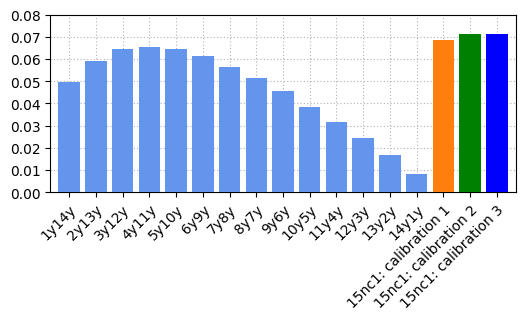

In [22]:
kappa = 0.00654818
dt = 1/252
paths = 10000
K = 0.03

# calibration 1
theta = 0.27000001
bs = np.array([0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395])
etas = np.array([1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044])
lambdas = np.array([0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994])
bermudan_1 = bermudan_price(K, kappa, theta, dt, paths, lambdas, etas, bs, swaprate_strip[0], cubic_swap_curve)[0]

# calibration 2
theta = 0.379404708181496
bs = np.array([0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495])
etas = np.array([1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443])
lambdas = np.array([0.31019157, 0.32745481, 0.32667033, 0.31896721, 0.30683361, 0.29715606, 0.28673488, 0.27939385, 0.27297822, 0.26892379, 0.26938024, 0.26940732, 0.27254794, 0.26907595])
bermudan_2 = bermudan_price(K, kappa, theta, dt, paths, lambdas, etas, bs, swaprate_strip[0], cubic_swap_curve)[0]

# calibration 3
theta = 0.379404708181496
bs = np.array([0.20914441, 0.21395428, 0.20897396, 0.2004646 , 0.19038863, 0.19244539, 0.19595601, 0.19932191, 0.20335474, 0.20738039, 0.23204294, 0.23611073, 0.2660578 , 0.28114119])
etas = np.array([1.57820697, 1.46156327, 1.5123661 , 1.47471207, 1.32609028, 1.41845365, 1.48493632, 1.53012501, 1.54337588, 1.51934625, 1.52744571, 1.51632786, 1.50961771, 1.5378323])
lambdas = np.array([0.31252499, 0.32716261, 0.32804561, 0.31906521, 0.30234794, 0.29556366, 0.28708199, 0.28092718, 0.27477928, 0.2700827, 0.27082702, 0.27060634, 0.27382635, 0.27106085])
bermudan_3 = bermudan_price(K, kappa, theta, dt, paths, lambdas, etas, bs, swaprate_strip[0], cubic_swap_curve)[0]

print(bermudan_1, bermudan_2, bermudan_3)

fig, ax = plt.subplots(figsize=(w,h))

plt.bar(europeans, european_cores, color = 'CornflowerBlue', zorder=3)
plt.bar('Bermudan 1', bermudan_1, color = '#ff7f0e', zorder=3)
plt.bar('Bermudan 2', bermudan_2, color = 'g', zorder=3)
plt.bar('Bermudan 3', bermudan_3, color = 'b', zorder=3)

ax.set_ylim(0, round(max(bermudan_1, bermudan_2, bermudan_3),2)+0.01)
ax.set_yticks(np.arange(0, round(max(bermudan_1, bermudan_2, bermudan_3),2)+0.02, 0.01))
ax.set_xlim(-0.7,16.7)
ax.set_xticklabels(['1y14y','2y13y','3y12y','4y11y','5y10y','6y9y','7y8y','8y7y','9y6y','10y5y', '11y4y','12y3y','13y2y','14y1y','15nc1: calibration 1', '15nc1: calibration 2', '15nc1: calibration 3' ], rotation = 45, ha = "right", rotation_mode = "anchor")
ax.grid(ls = (0,(1,2)), zorder=0)
fig.tight_layout()
# plt.savefig('C:/Users/Mikkel/OneDrive/CBS/CBS - FIN/THESIS/Main/python/billeder/bermudan_prices_15nc1_otm.pgf')
plt.show()

### with lower $\kappa$

In [ ]:
kappa = 0.000005
dt = 1/252
paths = 10000
K = 0.03

# calibration 1
theta = 0.27000001
bs = np.array([0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395])
etas = np.array([1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044])
lambdas = np.array([0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994])
bermudan_1 = bermudan_price(K, kappa, theta, dt, paths, lambdas, etas, bs, swaprate_strip[0], cubic_swap_curve)[0]

# calibration 2
theta = 0.379404708181496
bs = np.array([0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495])
etas = np.array([1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443])
lambdas = np.array([0.31019157, 0.32745481, 0.32667033, 0.31896721, 0.30683361, 0.29715606, 0.28673488, 0.27939385, 0.27297822, 0.26892379, 0.26938024, 0.26940732, 0.27254794, 0.26907595])
bermudan_2 = bermudan_price(K, kappa, theta, dt, paths, lambdas, etas, bs, swaprate_strip[0], cubic_swap_curve)[0]

# calibration 3
theta = 0.379404708181496
bs = np.array([0.20914441, 0.21395428, 0.20897396, 0.2004646 , 0.19038863, 0.19244539, 0.19595601, 0.19932191, 0.20335474, 0.20738039, 0.23204294, 0.23611073, 0.2660578 , 0.28114119])
etas = np.array([1.57820697, 1.46156327, 1.5123661 , 1.47471207, 1.32609028, 1.41845365, 1.48493632, 1.53012501, 1.54337588, 1.51934625, 1.52744571, 1.51632786, 1.50961771, 1.5378323])
lambdas = np.array([0.31252499, 0.32716261, 0.32804561, 0.31906521, 0.30234794, 0.29556366, 0.28708199, 0.28092718, 0.27477928, 0.2700827, 0.27082702, 0.27060634, 0.27382635, 0.27106085])
bermudan_3 = bermudan_price(K, kappa, theta, dt, paths, lambdas, etas, bs, swaprate_strip[0], cubic_swap_curve)[0]

fig, ax = plt.subplots(figsize=(w,h))

plt.bar(europeans, european_cores, color = 'CornflowerBlue', zorder=3)
plt.bar('Bermudan 1', bermudan_1, color = '#ff7f0e', zorder=3)
plt.bar('Bermudan 2', bermudan_2, color = 'g', zorder=3)
plt.bar('Bermudan 3', bermudan_3, color = 'b', zorder=3)

ax.set_ylim(0, round(max(bermudan_1, bermudan_2, bermudan_3),2)+0.01)
ax.set_yticks(np.arange(0, round(max(bermudan_1, bermudan_2, bermudan_3),2)+0.02, 0.01))
ax.set_xlim(-0.7,16.7)
ax.set_xticklabels(['1y14y','2y13y','3y12y','4y11y','5y10y','6y9y','7y8y','8y7y','9y6y','10y5y', '11y4y','12y3y','13y2y','14y1y','15nc1: calibration 1', '15nc1: calibration 2', '15nc1: calibration 3' ], rotation = 45, ha = "right", rotation_mode = "anchor")
fig.tight_layout()
ax.grid(ls = (0,(1,2)), zorder=0)
fig.tight_layout()
plt.savefig('C:/Users/Mikkel/OneDrive/CBS/CBS - FIN/THESIS/Main/python/billeder/bermudan_prices_15nc1_2.pgf')

C:\Users\Mikkel\AppData\Local\Temp\ipykernel_15296\996922911.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['1y14y','2y13y','3y12y','4y11y','5y10y','6y9y','7y8y','8y7y','9y6y','10y5y', '11y4y','12y3y','13y2y','14y1y','15nc1: calibration 1', '15nc1: calibration 2', '15nc1: calibration 3' ], rotation = 45, ha = "right", rotation_mode = "anchor")


### Bermudan as function of $\kappa$

In [ ]:
dt = 1/252
paths = 10000
K = 0.03

bermudan_prices_1 = []
bermudan_prices_2 = []
bermudan_prices_3 = []

kappas = np.arange(0.0005,1.0303,0.03)

theta = 0.27000001
bs = np.array([0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395])
etas = np.array([1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044])
lambdas = np.array([0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994])

for i in range(len(kappas)):
    kappa = kappas[i]
    bermudan_prices_1.append(bermudan_price(K, kappa, theta, dt, paths, lambdas, etas, bs, swaprate_strip[0], cubic_swap_curve)[0])

theta = 0.379404708181496
bs = np.array([0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495])
etas = np.array([1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443])
lambdas = np.array([0.31019157, 0.32745481, 0.32667033, 0.31896721, 0.30683361, 0.29715606, 0.28673488, 0.27939385, 0.27297822, 0.26892379, 0.26938024, 0.26940732, 0.27254794, 0.26907595])

for i in range(len(kappas)):
    kappa = kappas[i]
    bermudan_prices_2.append(bermudan_price(K, kappa, theta, dt, paths, lambdas, etas, bs, swaprate_strip[0], cubic_swap_curve)[0])

theta = 0.379404708181496
bs = np.array([0.20914441, 0.21395428, 0.20897396, 0.2004646 , 0.19038863, 0.19244539, 0.19595601, 0.19932191, 0.20335474, 0.20738039, 0.23204294, 0.23611073, 0.2660578 , 0.28114119])
etas = np.array([1.57820697, 1.46156327, 1.5123661 , 1.47471207, 1.32609028, 1.41845365, 1.48493632, 1.53012501, 1.54337588, 1.51934625, 1.52744571, 1.51632786, 1.50961771, 1.5378323])
lambdas = np.array([0.31252499, 0.32716261, 0.32804561, 0.31906521, 0.30234794, 0.29556366, 0.28708199, 0.28092718, 0.27477928, 0.2700827, 0.27082702, 0.27060634, 0.27382635, 0.27106085])

for i in range(len(kappas)):
    kappa = kappas[i]
    bermudan_prices_3.append(bermudan_price(K, kappa, theta, dt, paths, lambdas, etas, bs, swaprate_strip[0], cubic_swap_curve)[0])


In [ ]:
fig, ax = plt.subplots(figsize=(w,h))

ax.set_xlim(0, 1)
ax.set_ylim(0, 0.08)
ax.set_yticks(np.arange(0, 0.09, 0.01))
ax.grid(ls = (0,(1,2)))
plt.plot(kappas, bermudan_prices_1, color='#ff7f0e', label = 'Calibration 1')
plt.plot(kappas, bermudan_prices_2, color='g', label = 'Calibration 2')
plt.plot(kappas, bermudan_prices_3, color='b', label = 'Calibration 3')
plt.xlabel('$\\kappa$')
plt.legend(frameon=False, bbox_to_anchor = (1,1.015))
fig.tight_layout()
plt.savefig('C:/Users/Mikkel/OneDrive/CBS/CBS - FIN/THESIS/Main/python/billeder/berm_func_of_kappa.pgf')

### Bermudan as function of strike, K

In [ ]:
expiry = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14])
tenors = np.array([14,13,12,11,10,9,8,7,6,5,4,3,2,1])

kappa = 0.00654818
dt = 1/252
paths = 10000

theta = 0.379404708181496
b_calibrated = np.array([0.20914441, 0.21395428, 0.20897396, 0.2004646 , 0.19038863, 0.19244539, 0.19595601, 0.19932191, 0.20335474, 0.20738039, 0.23204294, 0.23611073, 0.2660578 , 0.28114119])
eta_calibrated = np.array([1.57820697, 1.46156327, 1.5123661 , 1.47471207, 1.32609028, 1.41845365, 1.48493632, 1.53012501, 1.54337588, 1.51934625, 1.52744571, 1.51632786, 1.50961771, 1.5378323])
lambd_calibrated = np.array([0.31252499, 0.32716261, 0.32804561, 0.31906521, 0.30234794, 0.29556366, 0.28708199, 0.28092718, 0.27477928, 0.2700827, 0.27082702, 0.27060634, 0.27382635, 0.27106085])

strikes = np.linspace(0.001,0.06,50)

europeans = []

for i in range(len(lambd_calibrated)):

    prices = pd.Series(np.zeros(len(strikes)),
                       index = strikes)

    for n in range(len(strikes)):
        K = strikes[n]
        european = payer_price_SV(swaprate_strip[0][i], K, swaprate_strip[0][i], theta, eta_calibrated[i], lambd_calibrated[i], b_calibrated[i], z_0, date, expiry[i], tenors[i])
        prices.iloc[n] = european

    europeans.append(prices)

bermudans_3 = pd.Series(np.zeros(len(strikes)),
                      index = strikes)

for n in range(len(strikes)):
    K = strikes[n]
    print("K = ", K)
    berm = bermudan_price(K, kappa, theta, dt, paths, lambd_calibrated, eta_calibrated, b_calibrated, swaprate_strip, cubic_swap_curve)[0]
    bermudans_3.iloc[n] = berm

theta = 0.27000001
bs = np.array([0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395])
etas = np.array([1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044])
lambdas = np.array([0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994])

bermudans_1 = pd.Series(np.zeros(len(strikes)),
                      index = strikes)

for n in range(len(strikes)):
    K = strikes[n]
    berm = bermudan_price(K, kappa, theta, dt, paths, lambd_calibrated, eta_calibrated, b_calibrated, swaprate_strip, cubic_swap_curve)[0]
    bermudans_1.iloc[n] = berm

theta = 0.379404708181496
bs = np.array([0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495])
etas = np.array([1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443])
lambdas = np.array([0.31019157, 0.32745481, 0.32667033, 0.31896721, 0.30683361, 0.29715606, 0.28673488, 0.27939385, 0.27297822, 0.26892379, 0.26938024, 0.26940732, 0.27254794, 0.26907595])

bermudans_2 = pd.Series(np.zeros(len(strikes)),
                      index = strikes)

for n in range(len(strikes)):
    K = strikes[n]
    berm = bermudan_price(K, kappa, theta, dt, paths, lambd_calibrated, eta_calibrated, b_calibrated, swaprate_strip, cubic_swap_curve)[0]
    bermudans_2.iloc[n] = berm

### With all 3

In [65]:
# latex_width = 6.69423 inches
w = 6.69423
golden_ratio = (5**.5 - 1) / 2
h = w * golden_ratio

In [ ]:
fig, ax = plt.subplots(figsize=(w,h))

ax.set_xlim(0.0015,0.06)
ax.set_ylim(0, 0.35)
ax.set_yticks(np.arange(0,0.40,0.05))
ax.grid(ls = (0,(1,2)))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1, decimals = 1))

plt.plot(bermudans_1.index, bermudans_1, color='m', label = '15nc1: calibration 1')
plt.plot(bermudans_2.index, bermudans_2, color='black', label = '15nc1: calibration 2')
plt.plot(bermudans_3.index, bermudans_3, color='b', label = '15nc1: calibration 3')

colors = plt.cm.jet(np.linspace(0.3,1,14))

plt.plot(europeans[0].index, europeans[0], label = '1y14y', color = colors[0])
plt.plot(europeans[1].index, europeans[1], label = '2y13y', color = colors[1])
plt.plot(europeans[2].index, europeans[2], label = '3y12y', color = colors[2])
plt.plot(europeans[3].index, europeans[3], label = '4y11y', color = colors[3])
plt.plot(europeans[4].index, europeans[4], label = '5y10y', color = colors[4])
plt.plot(europeans[5].index, europeans[5], label = '6y9y', color = colors[5])
plt.plot(europeans[6].index, europeans[6], label = '7y8y', color = colors[6])
plt.plot(europeans[7].index, europeans[7], label = '8y7y', color = colors[7])
plt.plot(europeans[8].index, europeans[8], label = '9y6y', color = colors[8])
plt.plot(europeans[9].index, europeans[9], label = '10y5y', color = colors[9])
plt.plot(europeans[10].index, europeans[10], label = '11y4y', color = colors[10])
plt.plot(europeans[11].index, europeans[11], label = '12y3y', color = colors[11])
plt.plot(europeans[12].index, europeans[12], label = '13y2y', color = colors[12])
plt.plot(europeans[13].index, europeans[13], label = '14y1y', color = colors[13])

plt.xlabel('Strike, $K$')
plt.legend(frameon=False,loc = 'upper right', ncol = 2)
fig.tight_layout()
plt.savefig('C:/Users/Mikkel/OneDrive/CBS/CBS - FIN/THESIS/Main/python/billeder/berm_func_of_strike_all_3.pgf')

### With only Calibration 3

In [ ]:
fig, ax = plt.subplots(figsize=(w,h))

ax.set_xlim(0.0015,0.06)
ax.set_ylim(0, 0.35)
ax.set_yticks(np.arange(0,0.40,0.05))
ax.grid(ls = (0,(1,2)))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1, decimals = 1))

plt.plot(bermudans_3.index, bermudans_3, color='b', label = '15nc1')

colors = plt.cm.jet(np.linspace(0.3,1,14))

plt.plot(europeans[0].index, europeans[0], label = '1y14y', color = colors[0])
plt.plot(europeans[1].index, europeans[1], label = '2y13y', color = colors[1])
plt.plot(europeans[2].index, europeans[2], label = '3y12y', color = colors[2])
plt.plot(europeans[3].index, europeans[3], label = '4y11y', color = colors[3])
plt.plot(europeans[4].index, europeans[4], label = '5y10y', color = colors[4])
plt.plot(europeans[5].index, europeans[5], label = '6y9y', color = colors[5])
plt.plot(europeans[6].index, europeans[6], label = '7y8y', color = colors[6])
plt.plot(europeans[7].index, europeans[7], label = '8y7y', color = colors[7])
plt.plot(europeans[8].index, europeans[8], label = '9y6y', color = colors[8])
plt.plot(europeans[9].index, europeans[9], label = '10y5y', color = colors[9])
plt.plot(europeans[10].index, europeans[10], label = '11y4y', color = colors[10])
plt.plot(europeans[11].index, europeans[11], label = '12y3y', color = colors[11])
plt.plot(europeans[12].index, europeans[12], label = '13y2y', color = colors[12])
plt.plot(europeans[13].index, europeans[13], label = '14y1y', color = colors[13])

plt.xlabel('Strike, $K$')
plt.legend(frameon=False,loc = 'upper right', ncol = 2)
fig.tight_layout()
plt.savefig('C:/Users/Mikkel/OneDrive/CBS/CBS - FIN/THESIS/Main/python/billeder/berm_func_of_strike.pgf')

### Bermudan as function of strike, K (too high $\kappa$)

In [64]:
expiry = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14])
tenors = np.array([14,13,12,11,10,9,8,7,6,5,4,3,2,1])

kappa = 0.05
dt = 1/252
paths = 10000

theta = 0.379404708181496
b_calibrated = np.array([0.20914441, 0.21395428, 0.20897396, 0.2004646 , 0.19038863, 0.19244539, 0.19595601, 0.19932191, 0.20335474, 0.20738039, 0.23204294, 0.23611073, 0.2660578 , 0.28114119])
eta_calibrated = np.array([1.57820697, 1.46156327, 1.5123661 , 1.47471207, 1.32609028, 1.41845365, 1.48493632, 1.53012501, 1.54337588, 1.51934625, 1.52744571, 1.51632786, 1.50961771, 1.5378323])
lambd_calibrated = np.array([0.31252499, 0.32716261, 0.32804561, 0.31906521, 0.30234794, 0.29556366, 0.28708199, 0.28092718, 0.27477928, 0.2700827, 0.27082702, 0.27060634, 0.27382635, 0.27106085])

strikes = np.linspace(0.001,0.06,50)

europeans_misc = []

for i in range(len(lambd_calibrated)):

    prices = pd.Series(np.zeros(len(strikes)),
                       index = strikes)

    for n in range(len(strikes)):
        K = strikes[n]
        european = payer_price_SV(swaprate_strip[0][i], K, swaprate_strip[0][i], theta, eta_calibrated[i], lambd_calibrated[i], b_calibrated[i], z_0, date, expiry[i], tenors[i])
        prices.iloc[n] = european

    europeans_misc.append(prices)

bermudans_3_misc = pd.Series(np.zeros(len(strikes)),
                      index = strikes)

for n in range(len(strikes)):
    K = strikes[n]
    print("K = ", K)
    berm = bermudan_price(K, kappa, theta, dt, paths, lambd_calibrated, eta_calibrated, b_calibrated, swaprate_strip, cubic_swap_curve)[0]
    bermudans_3_misc.iloc[n] = berm

theta = 0.27000001
bs = np.array([0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395, 0.28552126359807395])
etas = np.array([1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044, 1.5127555766521044])
lambdas = np.array([0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994, 0.30935653650722994])

bermudans_1_misc = pd.Series(np.zeros(len(strikes)),
                      index = strikes)

for n in range(len(strikes)):
    K = strikes[n]
    berm = bermudan_price(K, kappa, theta, dt, paths, lambd_calibrated, eta_calibrated, b_calibrated, swaprate_strip, cubic_swap_curve)[0]
    bermudans_1_misc.iloc[n] = berm

theta = 0.379404708181496
bs = np.array([0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495, 0.20342584463050495])
etas = np.array([1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443, 1.4714888854480443])
lambdas = np.array([0.31019157, 0.32745481, 0.32667033, 0.31896721, 0.30683361, 0.29715606, 0.28673488, 0.27939385, 0.27297822, 0.26892379, 0.26938024, 0.26940732, 0.27254794, 0.26907595])

bermudans_2_misc = pd.Series(np.zeros(len(strikes)),
                      index = strikes)

for n in range(len(strikes)):
    K = strikes[n]
    berm = bermudan_price(K, kappa, theta, dt, paths, lambd_calibrated, eta_calibrated, b_calibrated, swaprate_strip, cubic_swap_curve)[0]
    bermudans_2_misc.iloc[n] = berm

K =  0.001
K =  0.002204081632653061
K =  0.003408163265306122
K =  0.004612244897959183
K =  0.005816326530612244
K =  0.0070204081632653055
K =  0.008224489795918367
K =  0.009428571428571429
K =  0.01063265306122449
K =  0.01183673469387755
K =  0.013040816326530612
K =  0.014244897959183673
K =  0.015448979591836734
K =  0.016653061224489795
K =  0.017857142857142856
K =  0.019061224489795917
K =  0.02026530612244898
K =  0.02146938775510204
K =  0.0226734693877551
K =  0.02387755102040816
K =  0.025081632653061223
K =  0.026285714285714284
K =  0.027489795918367345
K =  0.028693877551020406
K =  0.029897959183673467
K =  0.031102040816326528
K =  0.03230612244897959
K =  0.03351020408163265
K =  0.03471428571428571
K =  0.035918367346938776
K =  0.037122448979591834
K =  0.03832653061224489
K =  0.039530612244897956
K =  0.04073469387755102
K =  0.04193877551020408
K =  0.043142857142857136
K =  0.0443469387755102
K =  0.045551020408163265
K =  0.04675510204081632
K =  0.047959183

### With all 3

In [ ]:
fig, ax = plt.subplots(figsize=(w,h))

ax.set_xlim(0.0015,0.06)
ax.set_ylim(0, 0.35)
ax.set_yticks(np.arange(0,0.40,0.05))
ax.grid(ls = (0,(1,2)))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1, decimals = 1))

plt.plot(bermudans_1_misc.index, bermudans_1_misc, color='m', label = '15nc1: calibration 1')
plt.plot(bermudans_2_misc.index, bermudans_2_misc, color='black', label = '15nc1: calibration 2')
plt.plot(bermudans_3_misc.index, bermudans_3_misc, color='b', label = '15nc1: calibration 3')

colors = plt.cm.jet(np.linspace(0.3,1,14))

plt.plot(europeans_misc[0].index, europeans_misc[0], label = '1y14y', color = colors[0])
plt.plot(europeans_misc[1].index, europeans_misc[1], label = '2y13y', color = colors[1])
plt.plot(europeans_misc[2].index, europeans_misc[2], label = '3y12y', color = colors[2])
plt.plot(europeans_misc[3].index, europeans_misc[3], label = '4y11y', color = colors[3])
plt.plot(europeans_misc[4].index, europeans_misc[4], label = '5y10y', color = colors[4])
plt.plot(europeans_misc[5].index, europeans_misc[5], label = '6y9y', color = colors[5])
plt.plot(europeans_misc[6].index, europeans_misc[6], label = '7y8y', color = colors[6])
plt.plot(europeans_misc[7].index, europeans_misc[7], label = '8y7y', color = colors[7])
plt.plot(europeans_misc[8].index, europeans_misc[8], label = '9y6y', color = colors[8])
plt.plot(europeans_misc[9].index, europeans_misc[9], label = '10y5y', color = colors[9])
plt.plot(europeans_misc[10].index, europeans_misc[10], label = '11y4y', color = colors[10])
plt.plot(europeans_misc[11].index, europeans_misc[11], label = '12y3y', color = colors[11])
plt.plot(europeans_misc[12].index, europeans_misc[12], label = '13y2y', color = colors[12])
plt.plot(europeans_misc[13].index, europeans_misc[13], label = '14y1y', color = colors[13])

plt.xlabel('Strike, $K$')
plt.legend(frameon=False,loc = 'upper right', ncol = 2)
fig.tight_layout()
plt.savefig('C:/Users/Mikkel/OneDrive/CBS/CBS - FIN/THESIS/Main/python/billeder/berm_func_of_strike_all_3_too_high_kappa.pgf')

### With only Calibration 3

In [66]:
fig, ax = plt.subplots(figsize=(w,h))

ax.set_xlim(0.0015,0.06)
ax.set_ylim(0, 0.35)
ax.set_yticks(np.arange(0,0.40,0.05))
ax.grid(ls = (0,(1,2)))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1, decimals = 1))

plt.plot(bermudans_3_misc.index, bermudans_3_misc, color='b', label = '15nc1')

colors = plt.cm.jet(np.linspace(0.3,1,14))

plt.plot(europeans_misc[0].index, europeans_misc[0], label = '1y14y', color = colors[0])
plt.plot(europeans_misc[1].index, europeans_misc[1], label = '2y13y', color = colors[1])
plt.plot(europeans_misc[2].index, europeans_misc[2], label = '3y12y', color = colors[2])
plt.plot(europeans_misc[3].index, europeans_misc[3], label = '4y11y', color = colors[3])
plt.plot(europeans_misc[4].index, europeans_misc[4], label = '5y10y', color = colors[4])
plt.plot(europeans_misc[5].index, europeans_misc[5], label = '6y9y', color = colors[5])
plt.plot(europeans_misc[6].index, europeans_misc[6], label = '7y8y', color = colors[6])
plt.plot(europeans_misc[7].index, europeans_misc[7], label = '8y7y', color = colors[7])
plt.plot(europeans_misc[8].index, europeans_misc[8], label = '9y6y', color = colors[8])
plt.plot(europeans_misc[9].index, europeans_misc[9], label = '10y5y', color = colors[9])
plt.plot(europeans_misc[10].index, europeans_misc[10], label = '11y4y', color = colors[10])
plt.plot(europeans_misc[11].index, europeans_misc[11], label = '12y3y', color = colors[11])
plt.plot(europeans_misc[12].index, europeans_misc[12], label = '13y2y', color = colors[12])
plt.plot(europeans_misc[13].index, europeans_misc[13], label = '14y1y', color = colors[13])

plt.xlabel('Strike, $K$')
plt.legend(frameon=False,loc = 'upper right', ncol = 2)
fig.tight_layout()
plt.savefig('C:/Users/Mikkel/OneDrive/CBS/CBS - FIN/THESIS/Main/python/billeder/berm_func_of_strike_too_high_kappa.pgf')

## 5nc1 Bermudan
###  Coterminal market strip

In [36]:
# latex_width = 6.69423 inches
w = 6.69423 * 8/10
golden_ratio = (5**.5 - 1) / 2
h = w * golden_ratio

In [37]:
swaption_expiry = np.array(["1Yr","2Yr","3Yr","4Yr"])
swaption_tenor  = np.array(["1Yr","2Yr","3Yr","4Yr"])

strike_strip = []
swaprate_strip = []
price_strip = []

for i in range(len(df_strike)):

    swaprate_strip_i = df_strike[0].loc["1Yr":"4Yr","1Yr"].copy()
    price_strip_i = df_strike[0].loc["1Yr":"4Yr","1Yr"].copy()
    strike_strip_i = df_strike[0].loc["1Yr":"4Yr","1Yr"].copy()

    for n in range(len(swaption_tenor)):

        expiry = swaption_expiry[n]     # forward loop from start
        tenor = swaption_tenor[-1-n]    # backward loop from end

        strike_strip_i[n] = df_strike[i].loc[expiry, tenor]
        swaprate_strip_i[n] = df_swap_rate[i].loc[expiry, tenor]
        price_strip_i[n] = df_price[i].loc[expiry, tenor]

    strike_strip.append(strike_strip_i)
    swaprate_strip.append(swaprate_strip_i)
    price_strip.append(price_strip_i)

### Calibration 1

In [ ]:
expiry = np.array([1,2,3,4])
tenors = np.array([4,3,2,1])

def pricing_fixed(lambd, b, eta, theta):

    M = len(expiry)
    prices = copy.deepcopy(price_strip)
    
    print("lambda =", lambd, "b =", b, "eta =", eta, "theta =", theta)
    for m in range(M):  # option expiry
        T = expiry[m]
        tenor = tenors[m]

        for i in range(len(strike_strip)): # strike level
            
            K = strike_strip[i][m]
            S = swaprate_strip[i][m]

            model_price = payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor)
            prices[i][m] = model_price

    return prices

# moneyness            +200  +100  +50  +25   ATM  -25   -50  -100  -200
weightings = np.array([0.05, 0.05, 0.1, 0.15, 0.3, 0.15, 0.1, 0.05, 0.05])

weights = copy.deepcopy(price_strip)
for n in range(len(weightings)):
    weights[n].iloc[:] = weightings[n]

bounds = ((1e-8, np.inf),(1e-8, 0.8),(1e-8, 3),(0.27, 1))

init_lambd = 0.25
init_b = 0.2
init_eta = 1.0
init_theta = 0.3
initguess = [init_lambd, init_b, init_eta, init_theta]

def Err(x):
    lambd, b, eta, theta = x
    err = np.sum(weights * (np.array(pricing_fixed(lambd, b, eta, theta)) - np.array(price_strip))**2)
    print("objective function =", err)
    return err

res = opt.minimize(Err, initguess, bounds = bounds, tol = 1e-12)
lambd, b, eta, theta = res.x

In [ ]:
b =	0.11658066361870387
eta = 0.7368051840087424
theta = 0.9926458860321857
lambd = 0.34926530560313584

### Calibration 2

In [ ]:
expiry = np.array([1,2,3,4])
tenors = np.array([4,3,2,1])

def pricing_lambd(b, eta, theta, lambda_1, lambda_2, lambda_3, lambda_4):

    lambdas = np.array([lambda_1, lambda_2, lambda_3, lambda_4])

    M = len(expiry)
    prices = copy.deepcopy(price_strip)
    
    for m in range(M):  # option expiry
        T = expiry[m]
        tenor = tenors[m]
        lambd = lambdas[m]

        print("b =", b, "eta = ", eta, "theta =", theta, "lambda =", lambd)
        for i in range(len(strike_strip)): # strike level
            
            K = strike_strip[i][m]
            S = swaprate_strip[i][m]

            model_price = payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor)
            prices[i][m] = model_price

    return prices

# moneyness            +200  +100  +50  +25   ATM  -25   -50  -100  -200
weightings = np.array([0.05, 0.05, 0.1, 0.15, 0.3, 0.15, 0.1, 0.05, 0.05])

weights = copy.deepcopy(price_strip)
for n in range(len(weightings)):
    weights[n].iloc[:] = weightings[n]

bounds = ((1e-8, np.inf),(1e-8, np.inf),(0.379404708181496, 0.379404708181496),
          (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf))

init_b = 0.15
init_eta = 1.5
init_theta = 0.40
init_lambda_1 = 0.3
init_lambda_2 = 0.3
init_lambda_3 = 0.3
init_lambda_4 = 0.3
initguess = [init_b, init_eta, init_theta,
             init_lambda_1, init_lambda_2, init_lambda_3, init_lambda_4]

def Err(x):
    b, eta, theta, lambda_1, lambda_2, lambda_3, lambda_4 = x
    err = np.sum(weights * (np.array(pricing_lambd(b, eta, theta, lambda_1, lambda_2, lambda_3, lambda_4))
                            -np.array(price_strip))**2)
    print("Objective function =", err)
    return err

res = opt.minimize(Err, initguess, bounds = bounds, tol = 1e-12)
b, eta, theta, lambda_1, lambda_2, lambda_3, lambda_4 = res.x
lambdas = pd.Series(data = np.array([lambda_1, lambda_2, lambda_3, lambda_4]), 
                    index = ["1Yr","2Yr","3Yr","4Yr"])

In [ ]:
b =	0.11305754285413212
eta = 1.4897781690551364
theta = 0.379404708181496
lambdas = np.array([0.34850838, 0.38474649, 0.39183218, 0.38349713])

### Calibration 3

In [ ]:
expiry = np.array([1,2,3,4])
tenors = np.array([4,3,2,1])

# moneyness         +200  +100  +50  +25   ATM  -25   -50  -100  -200
weights = np.array([0.05, 0.05, 0.1, 0.15, 0.3, 0.15, 0.1, 0.05, 0.05])

lambd_calibrated = price_strip[0].copy()
b_calibrated = price_strip[0].copy()
eta_calibrated = price_strip[0].copy()
model_prices = price_strip[0].copy()

theta = 0.379404708181496
M = len(expiry)

for m in range(M):  # calibrate swaption m
    T = expiry[m]
    tenor = tenors[m]
    print("Expiry = ", T, "Tenor = ", tenor)

    strikes_i = []
    swap_rate_i = []
    market_price_i = []

    for i in range(len(strike_strip)): # strikes loop

        strikes_i.append(strike_strip[i].iloc[m])
        swap_rate_i.append(swaprate_strip[i].iloc[m])
        market_price_i.append(price_strip[i].iloc[m])

    for p in range(1):  # calibrate (m,n)-swaption
        strikes = np.array(strikes_i)
        obs_prices = np.array(market_price_i)
        obs_swap_rates = np.array(swap_rate_i)

        bounds = ((1e-8, np.inf),(1e-8, np.inf),(1e-8, np.inf))

        init_lambd = 0.5
        init_b = 0.50
        init_eta = 0.50
        initguess = [init_lambd, init_b, init_eta]

        def Err(x):
            lambd, b, eta = x

            price_hat = []

            for i in range(len(strike_strip)):
                
                price_hat.append(payer_price_SV(obs_swap_rates[i], strikes[i], obs_swap_rates[i], theta, eta, lambd, b, z_0, date, T, tenor))

            price_hat = np.array(price_hat)
            err = np.sum(weights * (price_hat - obs_prices)**2)

            return err

    res = opt.minimize(Err, initguess, bounds = bounds, tol = 1e-14)
    lambd, b, eta = res.x

    lambd_calibrated[m] = lambd
    b_calibrated[m] = b
    eta_calibrated[m] = eta

    print('\n', "observed ATM price = ", market_price_i[4]) # market price
    print('\n', "calibrated ATM price = ", payer_price_SV(obs_swap_rates[4], strikes[4], obs_swap_rates[4], theta, eta, lambd, b, z_0, date, T, tenor))
    print('\n', 'calibrated lambda', lambd)
    print('\n', 'calibrated b', b)
    print('\n', 'calibrated eta', eta)

In [ ]:
theta = 0.379404708181496

lambd_calibrated = np.array([0.35376202, 0.38292605, 0.38977147, 0.37911044])
b_calibrated = np.array([0.00475537, 0.12264038, 0.1412259 , 0.17313736])
eta_calibrated = np.array([1.72602727, 1.43924873, 1.43655247, 1.37274629])

#### European prices

In [38]:
# calibration 3
lambdas = np.array([0.35376202, 0.38292605, 0.38977147, 0.37911044])
bs = np.array([0.00475537, 0.12264038, 0.1412259 , 0.17313736])
etas = np.array([1.72602727, 1.43924873, 1.43655247, 1.37274629])
theta = 0.379404708181496

expiry = np.array([1,2,3,4])
tenors = np.array([4,3,2,1])

european_cores = []

for i in range(len(lambdas)):

    S = swaprate_strip[0][i]
    K = 0.03
    eta = etas[i]
    lambd = lambdas[i]
    b = bs[i]
  
    T = expiry[i]
    tenor = tenors[i]

    european_price = payer_price_SV(S, K , S, theta, eta, lambd, b, z_0, date, T, tenor)
    european_cores.append(european_price)

europeans = ['1y4y','2y3y','3y2y','4y1y']

### Calibrating $\kappa$

In [ ]:
european_4y1y = 0.006799547865020846
paths = 10000
K = 0.03

lambdas = np.array([0.35376202, 0.38292605, 0.38977147, 0.37911044])
bs = np.array([0.00475537, 0.12264038, 0.1412259 , 0.17313736])
etas = np.array([1.72602727, 1.43924873, 1.43655247, 1.37274629])
theta = 0.379404708181496

initguess = [0.005]

def Err(x):
    kappa = x
    err = np.sum((european_4y1y - bermudan_price(K, kappa, theta, dt, paths, lambdas, etas, bs, swaprate_strip[0], cubic_swap_curve)[1])**2)

    return err

res = opt.minimize(Err, initguess, tol = 1e-10)
kappa = res.x

print("kappa =", 0.02386134)

#### Bermudan prices

0.020932445397806573 0.020285389721026427 0.020196724738752336


C:\Users\Mikkel\AppData\Local\Temp\ipykernel_780\3838985165.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['1y4y','2y3y','3y2y','4y1y','5nc1: calibration 1', '5nc1: calibration 2', '5nc1: calibration 3' ], rotation = 45, ha = "right", rotation_mode = "anchor")


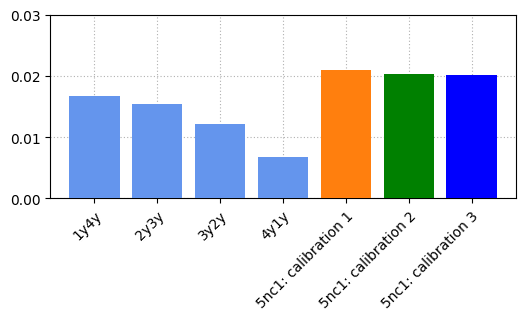

In [41]:
kappa = 0.02386134
dt = 1/252
paths = 10000
K = 0.03

# calibration 1
theta = 0.9926458860321857
bs = np.array([0.11658066361870387, 0.11658066361870387, 0.11658066361870387, 0.11658066361870387])
etas = np.array([0.7368051840087424,0.7368051840087424,0.7368051840087424,0.7368051840087424])
lambdas = np.array([0.34926530560313584, 0.34926530560313584, 0.34926530560313584, 0.34926530560313584]) 
bermudan_1 = bermudan_price(K, kappa, theta, dt, paths, lambdas, etas, bs, swaprate_strip[0], cubic_swap_curve)[0]

# calibration 2
theta = 0.379404708181496
bs = np.array([0.11305754285413212,0.11305754285413212,0.11305754285413212,0.11305754285413212])
etas = np.array([1.4897781690551364,1.4897781690551364,1.4897781690551364,1.4897781690551364])
lambdas = np.array([0.34850838, 0.38474649, 0.39183218, 0.38349713])
bermudan_2 = bermudan_price(K, kappa, theta, dt, paths, lambdas, etas, bs, swaprate_strip[0], cubic_swap_curve)[0]


# calibration 3
theta = 0.379404708181496
lambdas = np.array([0.35376202, 0.38292605, 0.38977147, 0.37911044])
bs = np.array([0.00475537, 0.12264038, 0.1412259 , 0.17313736])
etas = np.array([1.72602727, 1.43924873, 1.43655247, 1.37274629])
bermudan_3 = bermudan_price(K, kappa, theta, dt, paths, lambdas, etas, bs, swaprate_strip[0], cubic_swap_curve)[0]

print(bermudan_1, bermudan_2, bermudan_3)

fig, ax = plt.subplots(figsize=(w,h))

plt.bar(europeans, european_cores, color = 'CornflowerBlue', zorder=3)
plt.bar('Bermudan 1', bermudan_1, color = '#ff7f0e', zorder=3)
plt.bar('Bermudan 2', bermudan_2, color = 'g', zorder=3)
plt.bar('Bermudan 3', bermudan_3, color = 'b', zorder=3)

ax.set_ylim(0, 0.03)
ax.set_yticks(np.linspace(0, 0.03, 4))
ax.set_xlim(-0.7,6.7)
ax.set_xticklabels(['1y4y','2y3y','3y2y','4y1y','5nc1: calibration 1', '5nc1: calibration 2', '5nc1: calibration 3' ], rotation = 45, ha = "right", rotation_mode = "anchor")
fig.tight_layout()
ax.grid(ls = (0,(1,2)), zorder=0)
fig.tight_layout()
# plt.savefig('C:/Users/Mikkel/OneDrive/CBS/CBS - FIN/THESIS/Main/python/billeder/bermudan_prices_5nc1.pgf')
plt.show()

In [48]:
expiry = np.array([1,2,3,4])
tenors = np.array([4,3,2,1])

# 0.02386134

kappa = 0.02386134
dt = 1/252
paths = 10000

theta = 0.379404708181496
lambd_calibrated = np.array([0.35376202, 0.38292605, 0.38977147, 0.37911044])
b_calibrated = np.array([0.00475537, 0.12264038, 0.1412259 , 0.17313736])
eta_calibrated = np.array([1.72602727, 1.43924873, 1.43655247, 1.37274629])

strikes = np.linspace(0.001,0.06,50)

europeans = []

for i in range(len(lambd_calibrated)):

    prices = pd.Series(np.zeros(len(strikes)),
                       index = strikes)

    for n in range(len(strikes)):
        K = strikes[n]
        european = payer_price_SV(swaprate_strip[0][i], K, swaprate_strip[0][i], theta, eta_calibrated[i], lambd_calibrated[i], b_calibrated[i], z_0, date, expiry[i], tenors[i])
        prices.iloc[n] = european

    europeans.append(prices)

bermudans_3 = pd.Series(np.zeros(len(strikes)),
                      index = strikes)

for n in range(len(strikes)):
    K = strikes[n]
    print("K = ", K)
    berm = bermudan_price(K, kappa, theta, dt, paths, lambd_calibrated, eta_calibrated, b_calibrated, swaprate_strip, cubic_swap_curve)[0]
    bermudans_3.iloc[n] = berm

K =  0.001
K =  0.002204081632653061
K =  0.003408163265306122
K =  0.004612244897959183
K =  0.005816326530612244
K =  0.0070204081632653055
K =  0.008224489795918367
K =  0.009428571428571429
K =  0.01063265306122449
K =  0.01183673469387755
K =  0.013040816326530612
K =  0.014244897959183673
K =  0.015448979591836734
K =  0.016653061224489795
K =  0.017857142857142856
K =  0.019061224489795917
K =  0.02026530612244898
K =  0.02146938775510204
K =  0.0226734693877551
K =  0.02387755102040816
K =  0.025081632653061223
K =  0.026285714285714284
K =  0.027489795918367345
K =  0.028693877551020406
K =  0.029897959183673467
K =  0.031102040816326528
K =  0.03230612244897959
K =  0.03351020408163265
K =  0.03471428571428571
K =  0.035918367346938776
K =  0.037122448979591834
K =  0.03832653061224489
K =  0.039530612244897956
K =  0.04073469387755102
K =  0.04193877551020408
K =  0.043142857142857136
K =  0.0443469387755102
K =  0.045551020408163265
K =  0.04675510204081632
K =  0.047959183

In [49]:
# latex_width = 6.69423 inches
w = 6.69423
golden_ratio = (5**.5 - 1) / 2
h = w * golden_ratio

In [50]:
fig, ax = plt.subplots(figsize=(w,h))

ax.set_xlim(0.0015,0.06)
ax.set_ylim(0, 0.12)
ax.set_yticks(np.linspace(0,0.12,7))
ax.grid(ls = (0,(1,2)))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1, decimals = 1))

plt.plot(bermudans_3.index, bermudans_3, color='b', label = '5nc1')

colors = plt.cm.jet(np.linspace(0.3,1,4))

plt.plot(europeans[0].index, europeans[0], label = '1y4y', color = colors[0])
plt.plot(europeans[1].index, europeans[1], label = '2y3y', color = colors[1])
plt.plot(europeans[2].index, europeans[2], label = '3y2y', color = colors[2])
plt.plot(europeans[3].index, europeans[3], label = '4y1y', color = colors[3])

plt.xlabel('Strike, K')
plt.legend(frameon=False,loc = 'upper right')
fig.tight_layout()
plt.savefig('C:/Users/Mikkel/OneDrive/CBS/CBS - FIN/THESIS/Main/python/billeder/berm_func_of_strike_5nc1.pgf')

## 10nc1 Bermudan
###  Coterminal market strip

In [26]:
swaption_expiry = np.array(["1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr"])
swaption_tenor  = np.array(["1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr"])

strike_strip = []
swaprate_strip = []
price_strip = []

for i in range(len(df_strike)):

    swaprate_strip_i = df_strike[0].loc["1Yr":"9Yr","1Yr"].copy()
    price_strip_i = df_strike[0].loc["1Yr":"9Yr","1Yr"].copy()
    strike_strip_i = df_strike[0].loc["1Yr":"9Yr","1Yr"].copy()

    for n in range(len(swaption_tenor)):

        expiry = swaption_expiry[n]     # forward loop from start
        tenor = swaption_tenor[-1-n]    # backward loop from end

        strike_strip_i[n] = df_strike[i].loc[expiry, tenor]
        swaprate_strip_i[n] = df_swap_rate[i].loc[expiry, tenor]
        price_strip_i[n] = df_price[i].loc[expiry, tenor]

    strike_strip.append(strike_strip_i)
    swaprate_strip.append(swaprate_strip_i)
    price_strip.append(price_strip_i)

### Calibration 1

In [ ]:
expiry = np.array([1,2,3,4,5,6,7,8,9])
tenors = np.array([9,8,7,6,5,4,3,2,1])

def pricing_fixed(lambd, b, eta, theta):

    M = len(expiry)
    prices = copy.deepcopy(price_strip)
    
    print("lambda =", lambd, "b =", b, "eta =", eta, "theta =", theta)
    for m in range(M):  # option expiry
        T = expiry[m]
        tenor = tenors[m]

        for i in range(len(strike_strip)): # strike level
            
            K = strike_strip[i][m]
            S = swaprate_strip[i][m]

            model_price = payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor)
            prices[i][m] = model_price

    return prices

# moneyness            +200  +100  +50  +25   ATM  -25   -50  -100  -200
weightings = np.array([0.05, 0.05, 0.1, 0.15, 0.3, 0.15, 0.1, 0.05, 0.05])

weights = copy.deepcopy(price_strip)
for n in range(len(weightings)):
    weights[n].iloc[:] = weightings[n]

bounds = ((1e-8, np.inf),(1e-8, np.inf),(1e-8, np.inf),(0.27, np.inf))

init_lambd = 0.25
init_b = 0.2
init_eta = 1.0
init_theta = 0.3
initguess = [init_lambd, init_b, init_eta, init_theta]

def Err(x):
    lambd, b, eta, theta = x
    err = np.sum(weights * (np.array(pricing_fixed(lambd, b, eta, theta)) - np.array(price_strip))**2)
    print("objective function =", err)
    return err

res = opt.minimize(Err, initguess, bounds = bounds, tol = 1e-12)
lambd, b, eta, theta = res.x

In [ ]:
b =	0.21930497990595046
eta = 1.3153392969552855
theta = 0.27
lambd = 0.33744845864658163

### Calibration 2

In [ ]:
expiry = np.array([1,2,3,4,5,6,7,8,9])
tenors = np.array([9,8,7,6,5,4,3,2,1])

def pricing_lambd(b, eta, theta, lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9):

    lambdas = np.array([lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9])

    M = len(expiry)
    prices = copy.deepcopy(price_strip)
    
    for m in range(M):  # option expiry
        T = expiry[m]
        tenor = tenors[m]
        lambd = lambdas[m]

        print("b =", b, "eta = ", eta, "theta =", theta, "lambda =", lambd)
        for i in range(len(strike_strip)): # strike level
            
            K = strike_strip[i][m]
            S = swaprate_strip[i][m]

            model_price = payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor)
            prices[i][m] = model_price

    return prices

# moneyness            +200  +100  +50  +25   ATM  -25   -50  -100  -200
weightings = np.array([0.05, 0.05, 0.1, 0.15, 0.3, 0.15, 0.1, 0.05, 0.05])

weights = copy.deepcopy(price_strip)
for n in range(len(weightings)):
    weights[n].iloc[:] = weightings[n]

bounds = ((1e-8, np.inf),(1e-8, np.inf),(0.379404708181496, 0.379404708181496),
          (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf))

init_b = 0.15
init_eta = 1.5
init_theta = 0.40
init_lambda_1 = 0.3
init_lambda_2 = 0.3
init_lambda_3 = 0.3
init_lambda_4 = 0.3
init_lambda_5 = 0.3
init_lambda_6 = 0.3
init_lambda_7 = 0.3
init_lambda_8 = 0.3
init_lambda_9 = 0.3
initguess = [init_b, init_eta, init_theta,
             init_lambda_1, init_lambda_2, init_lambda_3, init_lambda_4, init_lambda_5, init_lambda_6, init_lambda_7, init_lambda_8, init_lambda_9]

def Err(x):
    b, eta, theta, lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9 = x
    err = np.sum(weights * (np.array(pricing_lambd(b, eta, theta, lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9))
                            -np.array(price_strip))**2)
    print("Objective function =", err)
    return err

res = opt.minimize(Err, initguess, bounds = bounds, tol = 1e-12)
b, eta, theta, lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9 = res.x
lambdas = pd.Series(data = np.array([lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9]), 
                    index = ["1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr"])

In [ ]:
b =	0.19658063963940653 
eta = 1.4905989910514241
theta = 0.379404708181496
lambdas = np.array([0.3292204326569119, 0.3527551663944037, 0.3521045801361138, 0.34228387066529303, 0.3303977808906562, 0.32180652778597957, 0.3163107875080656, 0.309829093946949, 0.29495363523738527])

### Calibration 3

In [ ]:
expiry = np.array([1,2,3,4,5,6,7,8,9])
tenors = np.array([9,8,7,6,5,4,3,2,1])

# moneyness         +200  +100  +50  +25   ATM  -25   -50  -100  -200
weights = np.array([0.05, 0.05, 0.1, 0.15, 0.3, 0.15, 0.1, 0.05, 0.05])

lambd_calibrated = price_strip[0].copy()
b_calibrated = price_strip[0].copy()
eta_calibrated = price_strip[0].copy()
model_prices = price_strip[0].copy()

theta = 0.379404708181496
M = len(expiry)

for m in range(M):  # calibrate swaption m
    T = expiry[m]
    tenor = tenors[m]
    print("Expiry = ", T, "Tenor = ", tenor)

    strikes_i = []
    swap_rate_i = []
    market_price_i = []

    for i in range(len(strike_strip)): # strikes loop

        strikes_i.append(strike_strip[i].iloc[m])
        swap_rate_i.append(swaprate_strip[i].iloc[m])
        market_price_i.append(price_strip[i].iloc[m])

    for p in range(1):  # calibrate (m,n)-swaption
        strikes = np.array(strikes_i)
        obs_prices = np.array(market_price_i)
        obs_swap_rates = np.array(swap_rate_i)

        bounds = ((1e-8, np.inf),(1e-8, np.inf),(1e-8, np.inf))

        init_lambd = 0.5
        init_b = 0.50
        init_eta = 0.50
        initguess = [init_lambd, init_b, init_eta]

        def Err(x):
            lambd, b, eta = x

            price_hat = []

            for i in range(len(strike_strip)):
                
                price_hat.append(payer_price_SV(obs_swap_rates[i], strikes[i], obs_swap_rates[i], theta, eta, lambd, b, z_0, date, T, tenor))

            price_hat = np.array(price_hat)
            err = np.sum(weights * (price_hat - obs_prices)**2)

            return err

    res = opt.minimize(Err, initguess, bounds = bounds, tol = 1e-14)
    lambd, b, eta = res.x

    lambd_calibrated[m] = lambd
    b_calibrated[m] = b
    eta_calibrated[m] = eta

    print('\n', "observed ATM price = ", market_price_i[4]) # market price
    print('\n', "calibrated ATM price = ", payer_price_SV(obs_swap_rates[4], strikes[4], obs_swap_rates[4], theta, eta, lambd, b, z_0, date, T, tenor))
    print('\n', 'calibrated lambda', lambd)
    print('\n', 'calibrated b', b)
    print('\n', 'calibrated eta', eta)

In [ ]:
theta = 0.379404708181496

lambd_calibrated = np.array([0.33188365, 0.35257935, 0.35325137, 0.34156719, 0.32450657, 0.31750145, 0.31195555, 0.30649471, 0.29229506])
b_calibrated = np.array([0.1728704, 0.18118124, 0.18003633, 0.19062064, 0.21062688, 0.21702723, 0.1970315 , 0.23731793, 0.24521783])
eta_calibrated = np.array([1.60404658, 1.48596508, 1.52336611, 1.47089641, 1.3110149, 1.3522574 , 1.34686759, 1.3679911, 1.38158914])

#### European prices

In [27]:
# calibration 3
lambdas = np.array([0.33188365, 0.35257935, 0.35325137, 0.34156719, 0.32450657, 0.31750145, 0.31195555, 0.30649471, 0.29229506])
bs = np.array([0.1728704, 0.18118124, 0.18003633, 0.19062064, 0.21062688, 0.21702723, 0.1970315 , 0.23731793, 0.24521783])
etas = np.array([1.60404658, 1.48596508, 1.52336611, 1.47089641, 1.3110149, 1.3522574 , 1.34686759, 1.3679911, 1.38158914])
theta = 0.379404708181496

expiry = np.array([1,2,3,4,5,6,7,8,9])
tenors = np.array([9,8,7,6,5,4,3,2,1])

european_cores = []

for i in range(len(lambdas)):

    S = swaprate_strip[0][i]
    K = 0.03
    eta = etas[i]
    lambd = lambdas[i]
    b = bs[i]
  
    T = expiry[i]
    tenor = tenors[i]

    european_price = payer_price_SV(S, K , S, theta, eta, lambd, b, z_0, date, T, tenor)
    european_cores.append(european_price)

europeans = ['1y9y','2y8y','3y7y','4y6y','5y5y','6y4y','7y3y','8y2y','9y1y']

### Calibrating $\kappa$

In [ ]:
european_9y1y = 0.008907338295447926
paths = 10000
K = 0.03

lambdas = np.array([0.33188365, 0.35257935, 0.35325137, 0.34156719, 0.32450657, 0.31750145, 0.31195555, 0.30649471, 0.29229506])
bs = np.array([0.1728704, 0.18118124, 0.18003633, 0.19062064, 0.21062688, 0.21702723, 0.1970315 , 0.23731793, 0.24521783])
etas = np.array([1.60404658, 1.48596508, 1.52336611, 1.47089641, 1.3110149, 1.3522574 , 1.34686759, 1.3679911, 1.38158914])
theta = 0.379404708181496

initguess = [0.005]

def Err(x):
    kappa = x
    err = np.sum((0.008907338295447926 - bermudan_price(K, kappa, theta, dt, paths, lambdas, etas, bs, swaprate_strip[0], cubic_swap_curve)[1])**2)

    return err

res = opt.minimize(Err, initguess, tol = 1e-16)
kappa = res.x

print("kappa =", 0.01510872)


### Bermudan prices

0.04571419106637954 0.045736744042170936 0.045706576967898815


C:\Users\Mikkel\AppData\Local\Temp\ipykernel_780\3270087115.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['1y9y','2y8y','3y7y','4y6y','5y5y','6y4y','7y3y','8y2y','9y1y','10nc1: calibration 1', '10nc1: calibration 2', '10nc1: calibration 3' ], rotation = 45, ha = "right", rotation_mode = "anchor")


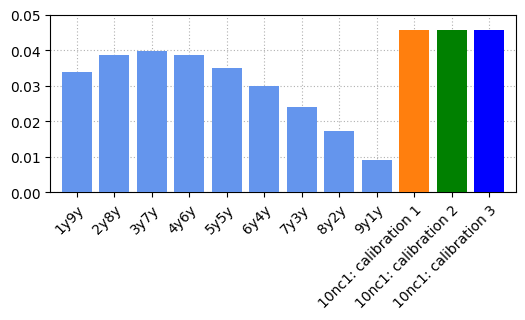

In [29]:
kappa = 0.01510872
dt = 1/252
paths = 10000
K = 0.03

# calibration 1
theta = 0.27000001
lambdas = np.array([0.33744845864658163, 0.33744845864658163, 0.33744845864658163, 0.33744845864658163, 0.33744845864658163, 0.33744845864658163, 0.33744845864658163, 0.33744845864658163, 0.33744845864658163])
etas = np.array([1.3153392969552855, 1.3153392969552855, 1.3153392969552855, 1.3153392969552855, 1.3153392969552855, 1.3153392969552855, 1.3153392969552855, 1.3153392969552855, 1.3153392969552855])
bs = np.array([0.21930497990595046, 0.21930497990595046, 0.21930497990595046, 0.21930497990595046, 0.21930497990595046, 0.21930497990595046, 0.21930497990595046, 0.21930497990595046, 0.21930497990595046])
bermudan_1 = bermudan_price(K, kappa, theta, dt, paths, lambdas, etas, bs, swaprate_strip[0], cubic_swap_curve)[0]

# calibration 2
theta = 0.379404708181496
bs = np.array([0.19658063963940653, 0.19658063963940653, 0.19658063963940653, 0.19658063963940653, 0.19658063963940653, 0.19658063963940653, 0.19658063963940653, 0.19658063963940653, 0.19658063963940653])
etas = np.array([1.4905989910514241, 1.4905989910514241, 1.4905989910514241, 1.4905989910514241, 1.4905989910514241, 1.4905989910514241, 1.4905989910514241, 1.4905989910514241, 1.4905989910514241])
lambdas = np.array([0.3292204326569119, 0.3527551663944037, 0.3521045801361138, 0.34228387066529303, 0.3303977808906562, 0.32180652778597957, 0.3163107875080656, 0.309829093946949, 0.29495363523738527])
bermudan_2 = bermudan_price(K, kappa, theta, dt, paths, lambdas, etas, bs, swaprate_strip[0], cubic_swap_curve)[0]

# calibration 3
theta = 0.379404708181496
lambdas = np.array([0.33188365, 0.35257935, 0.35325137, 0.34156719, 0.32450657, 0.31750145, 0.31195555, 0.30649471, 0.29229506])
bs = np.array([0.1728704, 0.18118124, 0.18003633, 0.19062064, 0.21062688, 0.21702723, 0.1970315 , 0.23731793, 0.24521783])
etas = np.array([1.60404658, 1.48596508, 1.52336611, 1.47089641, 1.3110149, 1.3522574 , 1.34686759, 1.3679911, 1.38158914])
bermudan_3 = bermudan_price(K, kappa, theta, dt, paths, lambdas, etas, bs, swaprate_strip[0], cubic_swap_curve)[0]

print(bermudan_1, bermudan_2, bermudan_3)

fig, ax = plt.subplots(figsize=(w,h))

plt.bar(europeans, european_cores, color = 'CornflowerBlue', zorder=3)
plt.bar('Bermudan 1', bermudan_1, color = '#ff7f0e', zorder=3)
plt.bar('Bermudan 2', bermudan_2, color = 'g', zorder=3)
plt.bar('Bermudan 3', bermudan_3, color = 'b', zorder=3)

ax.set_ylim(0, 0.05)
ax.set_yticks(np.linspace(0, 0.05, 6))
ax.set_xlim(-0.7,11.7)
ax.set_xticklabels(['1y9y','2y8y','3y7y','4y6y','5y5y','6y4y','7y3y','8y2y','9y1y','10nc1: calibration 1', '10nc1: calibration 2', '10nc1: calibration 3' ], rotation = 45, ha = "right", rotation_mode = "anchor")
fig.tight_layout()
ax.grid(ls = (0,(1,2)), zorder=0)
fig.tight_layout()
# plt.savefig('C:/Users/Mikkel/OneDrive/CBS/CBS - FIN/THESIS/Main/python/billeder/bermudan_prices_10nc1.pgf')
plt.show()

In [53]:
expiry = np.array([1,2,3,4,5,6,7,8,9])
tenors = np.array([9,8,7,6,5,4,3,2,1])

kappa = 0.01510872
dt = 1/252
paths = 10000

theta = 0.379404708181496
lambd_calibrated = np.array([0.33188365, 0.35257935, 0.35325137, 0.34156719, 0.32450657, 0.31750145, 0.31195555, 0.30649471, 0.29229506])
b_calibrated = np.array([0.1728704, 0.18118124, 0.18003633, 0.19062064, 0.21062688, 0.21702723, 0.1970315 , 0.23731793, 0.24521783])
eta_calibrated = np.array([1.60404658, 1.48596508, 1.52336611, 1.47089641, 1.3110149, 1.3522574 , 1.34686759, 1.3679911, 1.38158914])

strikes = np.linspace(0.001,0.06,50)

europeans = []

for i in range(len(lambd_calibrated)):

    prices = pd.Series(np.zeros(len(strikes)),
                       index = strikes)

    for n in range(len(strikes)):
        K = strikes[n]
        european = payer_price_SV(swaprate_strip[0][i], K, swaprate_strip[0][i], theta, eta_calibrated[i], lambd_calibrated[i], b_calibrated[i], z_0, date, expiry[i], tenors[i])
        prices.iloc[n] = european

    europeans.append(prices)

bermudans_3 = pd.Series(np.zeros(len(strikes)),
                      index = strikes)

for n in range(len(strikes)):
    K = strikes[n]
    print("K = ", K)
    berm = bermudan_price(K, kappa, theta, dt, paths, lambd_calibrated, eta_calibrated, b_calibrated, swaprate_strip, cubic_swap_curve)[0]
    bermudans_3.iloc[n] = berm

K =  0.001
K =  0.002204081632653061
K =  0.003408163265306122
K =  0.004612244897959183
K =  0.005816326530612244
K =  0.0070204081632653055
K =  0.008224489795918367
K =  0.009428571428571429
K =  0.01063265306122449
K =  0.01183673469387755
K =  0.013040816326530612
K =  0.014244897959183673
K =  0.015448979591836734
K =  0.016653061224489795
K =  0.017857142857142856
K =  0.019061224489795917
K =  0.02026530612244898
K =  0.02146938775510204
K =  0.0226734693877551
K =  0.02387755102040816
K =  0.025081632653061223
K =  0.026285714285714284
K =  0.027489795918367345
K =  0.028693877551020406
K =  0.029897959183673467
K =  0.031102040816326528
K =  0.03230612244897959
K =  0.03351020408163265
K =  0.03471428571428571
K =  0.035918367346938776
K =  0.037122448979591834
K =  0.03832653061224489
K =  0.039530612244897956
K =  0.04073469387755102
K =  0.04193877551020408
K =  0.043142857142857136
K =  0.0443469387755102
K =  0.045551020408163265
K =  0.04675510204081632
K =  0.047959183

In [54]:
# latex_width = 6.69423 inches
w = 6.69423
golden_ratio = (5**.5 - 1) / 2
h = w * golden_ratio

In [55]:
fig, ax = plt.subplots(figsize=(w,h))

ax.set_xlim(0.0015,0.06)
ax.set_ylim(0, 0.25)
ax.set_yticks(np.linspace(0,0.25,6))
ax.grid(ls = (0,(1,2)))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1, decimals = 1))

plt.plot(bermudans_3.index, bermudans_3, color='b', label = '10nc1')

colors = plt.cm.jet(np.linspace(0.3,1,9))

plt.plot(europeans[0].index, europeans[0], label = '1y9y', color = colors[0])
plt.plot(europeans[1].index, europeans[1], label = '2y8y', color = colors[1])
plt.plot(europeans[2].index, europeans[2], label = '3y7y', color = colors[2])
plt.plot(europeans[3].index, europeans[3], label = '4y6y', color = colors[3])
plt.plot(europeans[4].index, europeans[4], label = '5y5y', color = colors[4])
plt.plot(europeans[5].index, europeans[5], label = '6y4y', color = colors[5])
plt.plot(europeans[6].index, europeans[6], label = '7y3y', color = colors[6])
plt.plot(europeans[7].index, europeans[7], label = '8y2y', color = colors[7])
plt.plot(europeans[8].index, europeans[8], label = '9y1y', color = colors[8])

plt.xlabel('Strike, K')
plt.legend(frameon=False,loc = 'upper right')
fig.tight_layout()
plt.savefig('C:/Users/Mikkel/OneDrive/CBS/CBS - FIN/THESIS/Main/python/billeder/berm_func_of_strike_10nc1.pgf')

## 20nc1 Bermudan
###  Coterminal market strip

In [30]:
swaption_expiry = np.array(["1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "11Yr", "12Yr", "13Yr", "14Yr", "15Yr", "16Yr", "17Yr", "18Yr", "19Yr"])
swaption_tenor  = np.array(["1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "11Yr", "12Yr", "13Yr", "14Yr", "15Yr", "16Yr", "17Yr", "18Yr", "19Yr"])

strike_strip = []
swaprate_strip = []
price_strip = []

for i in range(len(df_strike)):

    swaprate_strip_i = df_strike[0].loc["1Yr":"19Yr","1Yr"].copy()
    price_strip_i = df_strike[0].loc["1Yr":"19Yr","1Yr"].copy()
    strike_strip_i = df_strike[0].loc["1Yr":"19Yr","1Yr"].copy()

    for n in range(len(swaption_tenor)):

        expiry = swaption_expiry[n]     # forward loop from start
        tenor = swaption_tenor[-1-n]    # backward loop from end

        strike_strip_i[n] = df_strike[i].loc[expiry, tenor]
        swaprate_strip_i[n] = df_swap_rate[i].loc[expiry, tenor]
        price_strip_i[n] = df_price[i].loc[expiry, tenor]

    strike_strip.append(strike_strip_i)
    swaprate_strip.append(swaprate_strip_i)
    price_strip.append(price_strip_i)

### Calibration 1

In [ ]:
expiry = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
tenors = np.array([19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1])

def pricing_fixed(lambd, b, eta, theta):

    M = len(expiry)
    prices = copy.deepcopy(price_strip)
    
    print("lambda =", lambd, "b =", b, "eta =", eta, "theta =", theta)
    for m in range(M):  # option expiry
        T = expiry[m]
        tenor = tenors[m]

        for i in range(len(strike_strip)): # strike level
            
            K = strike_strip[i][m]
            S = swaprate_strip[i][m]

            model_price = payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor)
            prices[i][m] = model_price

    return prices

# moneyness            +200  +100  +50  +25   ATM  -25   -50  -100  -200
weightings = np.array([0.05, 0.05, 0.1, 0.15, 0.3, 0.15, 0.1, 0.05, 0.05])

weights = copy.deepcopy(price_strip)
for n in range(len(weightings)):
    weights[n].iloc[:] = weightings[n]

bounds = ((1e-8, np.inf),(1e-8, np.inf),(1e-8, np.inf),(0.27, np.inf))

init_lambd = 0.25
init_b = 0.2
init_eta = 1.0
init_theta = 0.3
initguess = [init_lambd, init_b, init_eta, init_theta]

def Err(x):
    lambd, b, eta, theta = x
    err = np.sum(weights * (np.array(pricing_fixed(lambd, b, eta, theta)) - np.array(price_strip))**2)
    print("objective function =", err)
    return err

res = opt.minimize(Err, initguess, bounds = bounds, tol = 1e-12)
lambd, b, eta, theta = res.x

In [ ]:
b =	0.20891436667859092
eta = 1.3666111052267118
theta = 0.27000001
lambd = 0.2954235005849251

### Calibration 2

In [ ]:
expiry = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
tenors = np.array([19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1])

def pricing_lambd(b, eta, theta, lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9, lambda_10, lambda_11, lambda_12, lambda_13, lambda_14, lambda_15, lambda_16, lambda_17, lambda_18, lambda_19):

    lambdas = np.array([lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9, lambda_10, lambda_11, lambda_12, lambda_13, lambda_14, lambda_15, lambda_16, lambda_17, lambda_18, lambda_19])

    M = len(expiry)
    prices = copy.deepcopy(price_strip)
    
    for m in range(M):  # option expiry
        T = expiry[m]
        tenor = tenors[m]
        lambd = lambdas[m]

        print("b =", b, "eta = ", eta, "theta =", theta, "lambda =", lambd)
        for i in range(len(strike_strip)): # strike level
            
            K = strike_strip[i][m]
            S = swaprate_strip[i][m]

            model_price = payer_price_SV(S, K, S, theta, eta, lambd, b, z_0, date, T, tenor)
            prices[i][m] = model_price

    return prices

# moneyness            +200  +100  +50  +25   ATM  -25   -50  -100  -200
weightings = np.array([0.05, 0.05, 0.1, 0.15, 0.3, 0.15, 0.1, 0.05, 0.05])

weights = copy.deepcopy(price_strip)
for n in range(len(weightings)):
    weights[n].iloc[:] = weightings[n]

bounds = ((1e-8, np.inf),(1e-8, np.inf),(0.379404708181496, 0.379404708181496),
          (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), 
          (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf), (1e-8, np.inf))

init_b = 0.15
init_eta = 1.5
init_theta = 0.40
init_lambda_1 = 0.3
init_lambda_2 = 0.3
init_lambda_3 = 0.3
init_lambda_4 = 0.3
init_lambda_5 = 0.3
init_lambda_6 = 0.3
init_lambda_7 = 0.3
init_lambda_8 = 0.3
init_lambda_9 = 0.3
init_lambda_10 = 0.3
init_lambda_11 = 0.3
init_lambda_12 = 0.3
init_lambda_13 = 0.3
init_lambda_14 = 0.3
init_lambda_15 = 0.3
init_lambda_16 = 0.3
init_lambda_17 = 0.3
init_lambda_18 = 0.3
init_lambda_19 = 0.3
initguess = [init_b, init_eta, init_theta,
             init_lambda_1, init_lambda_2, init_lambda_3, init_lambda_4, init_lambda_5, init_lambda_6, init_lambda_7, init_lambda_8, init_lambda_9, init_lambda_10, init_lambda_11, init_lambda_12, init_lambda_13, init_lambda_14, init_lambda_15, init_lambda_16, init_lambda_17, init_lambda_18, init_lambda_19]

def Err(x):
    b, eta, theta, lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9, lambda_10, lambda_11, lambda_12, lambda_13, lambda_14, lambda_15, lambda_16, lambda_17, lambda_18, lambda_19 = x
    err = np.sum(weights * (np.array(pricing_lambd(b, eta, theta, lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9, lambda_10, lambda_11, lambda_12, lambda_13, lambda_14, lambda_15, lambda_16, lambda_17, lambda_18, lambda_19))
                            -np.array(price_strip))**2)
    print("Objective function =", err)
    return err

res = opt.minimize(Err, initguess, bounds = bounds, tol = 1e-12)
b, eta, theta, lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9, lambda_10, lambda_11, lambda_12, lambda_13, lambda_14, lambda_15, lambda_16, lambda_17, lambda_18, lambda_19 = res.x
lambdas = pd.Series(data = np.array([lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9, lambda_10, lambda_11, lambda_12, lambda_13, lambda_14, lambda_15, lambda_16, lambda_17, lambda_18, lambda_19]), 
                    index = ["1Mo","3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"])

In [ ]:
b = 0.16662601758136245
eta = 1.4774123099294305
theta = 0.379404708181496
lambdas = pd.Series(data = np.array([0.3056834 , 0.32158634, 0.32035852, 0.31258137, 0.30140343, 0.29393848, 0.28617513, 0.27892284, 0.27405485, 0.26961037, 0.26910762, 0.26992212, 0.27178778, 0.27518986, 0.28242963, 0.28726692, 0.2910441 , 0.29531973, 0.29225949]), 
                    index = ["1Mo","3Mo","6Mo","9Mo","1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "12Yr","15Yr","20Yr", "25Yr", "30Yr"])

### Calibration 3

In [ ]:
expiry = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
tenors = np.array([19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1])

# moneyness         +200  +100  +50  +25   ATM  -25   -50  -100  -200
weights = np.array([0.05, 0.05, 0.1, 0.15, 0.3, 0.15, 0.1, 0.05, 0.05])

lambd_calibrated = price_strip[0].copy()
b_calibrated = price_strip[0].copy()
eta_calibrated = price_strip[0].copy()
model_prices = price_strip[0].copy()

theta = 0.379404708181496
M = len(expiry)

for m in range(M):  # calibrate swaption m
    T = expiry[m]
    tenor = tenors[m]
    print("Expiry = ", T, "Tenor = ", tenor)

    strikes_i = []
    swap_rate_i = []
    market_price_i = []

    for i in range(len(strike_strip)): # strikes loop

        strikes_i.append(strike_strip[i].iloc[m])
        swap_rate_i.append(swaprate_strip[i].iloc[m])
        market_price_i.append(price_strip[i].iloc[m])

    for p in range(1):  # calibrate (m,n)-swaption
        strikes = np.array(strikes_i)
        obs_prices = np.array(market_price_i)
        obs_swap_rates = np.array(swap_rate_i)

        bounds = ((1e-8, np.inf),(1e-8, np.inf),(1e-8, np.inf))

        init_lambd = 0.5
        init_b = 0.50
        init_eta = 0.50
        initguess = [init_lambd, init_b, init_eta]

        def Err(x):
            lambd, b, eta = x

            price_hat = []

            for i in range(len(strike_strip)):
                
                price_hat.append(payer_price_SV(obs_swap_rates[i], strikes[i], obs_swap_rates[i], theta, eta, lambd, b, z_0, date, T, tenor))

            price_hat = np.array(price_hat)
            err = np.sum(weights * (price_hat - obs_prices)**2)

            return err

    res = opt.minimize(Err, initguess, bounds = bounds, tol = 1e-14)
    lambd, b, eta = res.x

    lambd_calibrated[m] = lambd
    b_calibrated[m] = b
    eta_calibrated[m] = eta

    print('\n', "observed ATM price = ", market_price_i[4]) # market price
    print('\n', "calibrated ATM price = ", payer_price_SV(obs_swap_rates[4], strikes[4], obs_swap_rates[4], theta, eta, lambd, b, z_0, date, T, tenor))
    print('\n', 'calibrated lambda', lambd)
    print('\n', 'calibrated b', b)
    print('\n', 'calibrated eta', eta)

In [ ]:
theta = 0.379404708181496

lambd_calibrated = np.array([0.30745666, 0.31998112, 0.32030697, 0.3116415 , 0.29668979, 0.2922619 , 0.28687346, 0.28136226, 0.27681879, 0.27377777, 0.27391536, 0.2747742 , 0.27658182, 0.27946444, 0.2856533, 0.29013932, 0.29335701, 0.29714964, 0.29369573])
b_calibrated = np.array([0.16742349, 0.17048661, 0.1745532 , 0.17584704, 0.17523996, 0.17366574, 0.17042437, 0.16495084, 0.12140896, 0.14615985, 0.1606869 , 0.16399058, 0.17519446, 0.17904733, 0.17411346, 0.1930814 , 0.21002483, 0.22534451, 0.22696482])
eta_calibrated = np.array([1.5605828 , 1.42328526, 1.47545642, 1.44735756, 1.31879797, 1.41867505, 1.50233187, 1.57036451, 1.59282986, 1.65338718, 1.68384853, 1.69073158, 1.69040665, 1.66943619, 1.62360644, 1.60202822, 1.56960267, 1.53886673, 1.52000955])

#### European prices

In [31]:
# calibration 3
lambdas = np.array([0.30745666, 0.31998112, 0.32030697, 0.3116415 , 0.29668979, 0.2922619 , 0.28687346, 0.28136226, 0.27681879, 0.27377777, 0.27391536, 0.2747742 , 0.27658182, 0.27946444, 0.2856533, 0.29013932, 0.29335701, 0.29714964, 0.29369573])
bs = np.array([0.16742349, 0.17048661, 0.1745532 , 0.17584704, 0.17523996, 0.17366574, 0.17042437, 0.16495084, 0.12140896, 0.14615985, 0.1606869 , 0.16399058, 0.17519446, 0.17904733, 0.17411346, 0.1930814 , 0.21002483, 0.22534451, 0.22696482])
etas = np.array([1.5605828 , 1.42328526, 1.47545642, 1.44735756, 1.31879797, 1.41867505, 1.50233187, 1.57036451, 1.59282986, 1.65338718, 1.68384853, 1.69073158, 1.69040665, 1.66943619, 1.62360644, 1.60202822, 1.56960267, 1.53886673, 1.52000955])
theta = 0.379404708181496

expiry = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
tenors = np.array([19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1])

european_cores = []

for i in range(len(lambdas)):

    S = swaprate_strip[0][i]
    K = 0.03
    eta = etas[i]
    lambd = lambdas[i]
    b = bs[i]
  
    T = expiry[i]
    tenor = tenors[i]

    european_price = payer_price_SV(S, K , S, theta, eta, lambd, b, z_0, date, T, tenor)
    european_cores.append(european_price)

europeans = ['1y19y','2y18y','3y17y','4y16y','5y15y','6y14y','7y13y','8y12y','9y11y','10y10y', '11y9y','12y8y','13y7y','14y6y','15y5y','16y4y','17y3y','18y2y','19y1y']

### Calibrating $\kappa$

In [ ]:
european_19y1y = 0.00645640329148604
paths = 10000
K = 0.03

lambdas = np.array([0.30745666, 0.31998112, 0.32030697, 0.3116415 , 0.29668979, 0.2922619 , 0.28687346, 0.28136226, 0.27681879, 0.27377777, 0.27391536, 0.2747742 , 0.27658182, 0.27946444, 0.2856533, 0.29013932, 0.29335701, 0.29714964, 0.29369573])
bs = np.array([0.16742349, 0.17048661, 0.1745532 , 0.17584704, 0.17523996, 0.17366574, 0.17042437, 0.16495084, 0.12140896, 0.14615985, 0.1606869 , 0.16399058, 0.17519446, 0.17904733, 0.17411346, 0.1930814 , 0.21002483, 0.22534451, 0.22696482])
etas = np.array([1.5605828 , 1.42328526, 1.47545642, 1.44735756, 1.31879797, 1.41867505, 1.50233187, 1.57036451, 1.59282986, 1.65338718, 1.68384853, 1.69073158, 1.69040665, 1.66943619, 1.62360644, 1.60202822, 1.56960267, 1.53886673, 1.52000955])
theta = 0.379404708181496

initguess = [0.005]

def Err(x):
    kappa = x
    err = np.sum((european_19y1y - bermudan_price(K, kappa, theta, dt, paths, lambdas, etas, bs, swaprate_strip[0], cubic_swap_curve)[1])**2)

    return err

res = opt.minimize(Err, initguess, tol = 1e-10)
kappa = res.x

print("kappa =", 0.00478659)


### Bermudan prices

0.08409320036173472 0.08777628979409502 0.08964840199197165


C:\Users\Mikkel\AppData\Local\Temp\ipykernel_780\722459386.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['1y19y','2y18y','3y17y','4y16y','5y15y','6y14y','7y13y','8y12y','9y11y','10y10y', '11y9y','12y8y','13y7y','14y6y','15y5y','16y4y','17y3y','18y2y','19y1y','20nc1: calibration 1', '20nc1: calibration 2', '20nc1: calibration 3' ], rotation = 45, ha = "right", rotation_mode = "anchor")


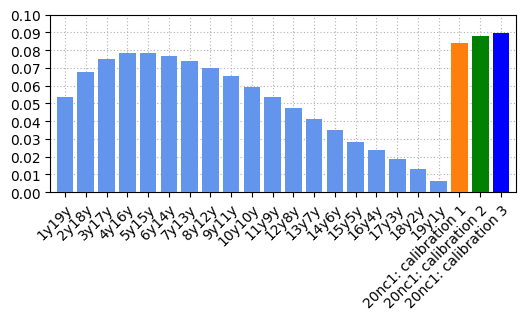

In [32]:
kappa = 0.00478659
dt = 1/252
paths = 1000
K = 0.03

# calibration 1
theta = 0.27000001
bs = np.array([0.20891436667859092, 0.20891436667859092, 0.20891436667859092, 0.20891436667859092, 0.20891436667859092, 0.20891436667859092, 0.20891436667859092, 0.20891436667859092, 0.20891436667859092, 0.20891436667859092, 0.20891436667859092, 0.20891436667859092, 0.20891436667859092, 0.20891436667859092, 0.20891436667859092, 0.20891436667859092, 0.20891436667859092, 0.20891436667859092, 0.20891436667859092])
etas = np.array([1.3666111052267118, 1.3666111052267118, 1.3666111052267118, 1.3666111052267118, 1.3666111052267118, 1.3666111052267118, 1.3666111052267118, 1.3666111052267118, 1.3666111052267118, 1.3666111052267118, 1.3666111052267118, 1.3666111052267118, 1.3666111052267118, 1.3666111052267118, 1.3666111052267118, 1.3666111052267118, 1.3666111052267118, 1.3666111052267118, 1.3666111052267118,])
lambdas = np.array([0.2954235005849251, 0.2954235005849251, 0.2954235005849251, 0.2954235005849251, 0.2954235005849251, 0.2954235005849251, 0.2954235005849251, 0.2954235005849251, 0.2954235005849251, 0.2954235005849251, 0.2954235005849251, 0.2954235005849251, 0.2954235005849251, 0.2954235005849251, 0.2954235005849251, 0.2954235005849251, 0.2954235005849251, 0.2954235005849251, 0.2954235005849251])
bermudan_1 = bermudan_price(K, kappa, theta, dt, paths, lambdas, etas, bs, swaprate_strip[0], cubic_swap_curve)[0]

# calibration 2
theta = 0.379404708181496
bs = np.array([0.16662601758136245, 0.16662601758136245, 0.16662601758136245, 0.16662601758136245, 0.16662601758136245, 0.16662601758136245, 0.16662601758136245, 0.16662601758136245, 0.16662601758136245, 0.16662601758136245, 0.16662601758136245, 0.166626017581362455, 0.16662601758136245, 0.16662601758136245, 0.16662601758136245, 0.16662601758136245, 0.16662601758136245, 0.16662601758136245, 0.16662601758136245])
etas = np.array([1.4774123099294305, 1.4774123099294305, 1.4774123099294305, 1.4774123099294305, 1.4774123099294305, 1.4774123099294305, 1.4774123099294305, 1.4774123099294305, 1.4774123099294305, 1.4774123099294305, 1.4774123099294305, 1.4774123099294305, 1.4774123099294305, 1.4774123099294305, 1.4774123099294305, 1.4774123099294305, 1.4774123099294305, 1.4774123099294305, 1.4774123099294305])
lambdas = np.array([0.3056834 , 0.32158634, 0.32035852, 0.31258137, 0.30140343, 0.29393848, 0.28617513, 0.27892284, 0.27405485, 0.26961037, 0.26910762, 0.26992212, 0.27178778, 0.27518986, 0.28242963, 0.28726692, 0.2910441 , 0.29531973, 0.29225949])
bermudan_2 = bermudan_price(K, kappa, theta, dt, paths, lambdas, etas, bs, swaprate_strip[0], cubic_swap_curve)[0]

# calibration 3
theta = 0.379404708181496
bs = np.array([0.16742349, 0.17048661, 0.1745532 , 0.17584704, 0.17523996, 0.17366574, 0.17042437, 0.16495084, 0.12140896, 0.14615985, 0.1606869 , 0.16399058, 0.17519446, 0.17904733, 0.17411346, 0.1930814 , 0.21002483, 0.22534451, 0.22696482])
etas = np.array([1.5605828 , 1.42328526, 1.47545642, 1.44735756, 1.31879797, 1.41867505, 1.50233187, 1.57036451, 1.59282986, 1.65338718, 1.68384853, 1.69073158, 1.69040665, 1.66943619, 1.62360644, 1.60202822, 1.56960267, 1.53886673, 1.52000955])
lambdas = np.array([0.30745666, 0.31998112, 0.32030697, 0.3116415 , 0.29668979, 0.2922619 , 0.28687346, 0.28136226, 0.27681879, 0.27377777, 0.27391536, 0.2747742 , 0.27658182, 0.27946444, 0.2856533, 0.29013932, 0.29335701, 0.29714964, 0.29369573])
bermudan_3 = bermudan_price(K, kappa, theta, dt, paths, lambdas, etas, bs, swaprate_strip[0], cubic_swap_curve)[0]

print(bermudan_1, bermudan_2, bermudan_3)

fig, ax = plt.subplots(figsize =(w,h))

plt.bar(europeans, european_cores, color = 'CornflowerBlue', zorder=3)
plt.bar('Bermudan 1', bermudan_1, color = '#ff7f0e', zorder=3)
plt.bar('Bermudan 2', bermudan_2, color = 'g', zorder=3)
plt.bar('Bermudan 3', bermudan_3, color = 'b', zorder=3)

ax.set_ylim(0, round(max(bermudan_1, bermudan_2, bermudan_3),2)+0.01)
ax.set_yticks(np.arange(0, round(max(bermudan_1, bermudan_2, bermudan_3),2)+0.02, 0.01))
ax.set_xlim(-0.7,21.7)
ax.set_xticklabels(['1y19y','2y18y','3y17y','4y16y','5y15y','6y14y','7y13y','8y12y','9y11y','10y10y', '11y9y','12y8y','13y7y','14y6y','15y5y','16y4y','17y3y','18y2y','19y1y','20nc1: calibration 1', '20nc1: calibration 2', '20nc1: calibration 3' ], rotation = 45, ha = "right", rotation_mode = "anchor")
fig.tight_layout()
ax.grid(ls = (0,(1,2)), zorder=0)
fig.tight_layout()
# plt.savefig('C:/Users/Mikkel/OneDrive/CBS/CBS - FIN/THESIS/Main/python/billeder/bermudan_prices_20nc1.pgf')
plt.show()

In [57]:
expiry = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])
tenors = np.array([19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1])

kappa = 0.00478659
dt = 1/252
paths = 10000

theta = 0.379404708181496
b_calibrated = np.array([0.16742349, 0.17048661, 0.1745532 , 0.17584704, 0.17523996, 0.17366574, 0.17042437, 0.16495084, 0.12140896, 0.14615985, 0.1606869 , 0.16399058, 0.17519446, 0.17904733, 0.17411346, 0.1930814 , 0.21002483, 0.22534451, 0.22696482])
eta_calibrated = np.array([1.5605828 , 1.42328526, 1.47545642, 1.44735756, 1.31879797, 1.41867505, 1.50233187, 1.57036451, 1.59282986, 1.65338718, 1.68384853, 1.69073158, 1.69040665, 1.66943619, 1.62360644, 1.60202822, 1.56960267, 1.53886673, 1.52000955])
lambd_calibrated = np.array([0.30745666, 0.31998112, 0.32030697, 0.3116415 , 0.29668979, 0.2922619 , 0.28687346, 0.28136226, 0.27681879, 0.27377777, 0.27391536, 0.2747742 , 0.27658182, 0.27946444, 0.2856533, 0.29013932, 0.29335701, 0.29714964, 0.29369573])

strikes = np.linspace(0.001,0.06,50)

europeans = []

for i in range(len(lambd_calibrated)):

    prices = pd.Series(np.zeros(len(strikes)),
                       index = strikes)

    for n in range(len(strikes)):
        K = strikes[n]
        european = payer_price_SV(swaprate_strip[0][i], K, swaprate_strip[0][i], theta, eta_calibrated[i], lambd_calibrated[i], b_calibrated[i], z_0, date, expiry[i], tenors[i])
        prices.iloc[n] = european

    europeans.append(prices)

bermudans_3 = pd.Series(np.zeros(len(strikes)),
                      index = strikes)

for n in range(len(strikes)):
    K = strikes[n]
    print("K = ", K)
    berm = bermudan_price(K, kappa, theta, dt, paths, lambd_calibrated, eta_calibrated, b_calibrated, swaprate_strip, cubic_swap_curve)[0]
    bermudans_3.iloc[n] = berm

K =  0.001
K =  0.002204081632653061
K =  0.003408163265306122
K =  0.004612244897959183
K =  0.005816326530612244
K =  0.0070204081632653055
K =  0.008224489795918367
K =  0.009428571428571429
K =  0.01063265306122449
K =  0.01183673469387755
K =  0.013040816326530612
K =  0.014244897959183673
K =  0.015448979591836734
K =  0.016653061224489795
K =  0.017857142857142856
K =  0.019061224489795917
K =  0.02026530612244898
K =  0.02146938775510204
K =  0.0226734693877551
K =  0.02387755102040816
K =  0.025081632653061223
K =  0.026285714285714284
K =  0.027489795918367345
K =  0.028693877551020406
K =  0.029897959183673467
K =  0.031102040816326528
K =  0.03230612244897959
K =  0.03351020408163265
K =  0.03471428571428571
K =  0.035918367346938776
K =  0.037122448979591834
K =  0.03832653061224489
K =  0.039530612244897956
K =  0.04073469387755102
K =  0.04193877551020408
K =  0.043142857142857136
K =  0.0443469387755102
K =  0.045551020408163265
K =  0.04675510204081632
K =  0.047959183

In [58]:
# latex_width = 6.69423 inches
w = 6.69423
golden_ratio = (5**.5 - 1) / 2
h = w * golden_ratio

In [61]:
fig, ax = plt.subplots(figsize=(w,h))

ax.set_xlim(0.0015,0.06)
ax.set_ylim(0, 0.5)
# ax.set_yticks(np.linspace(0,0.12,7))
ax.grid(ls = (0,(1,2)))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1, decimals = 1))

plt.plot(bermudans_3.index, bermudans_3, color='b', label = '20nc1')

colors = plt.cm.jet(np.linspace(0.3,1,19))

plt.plot(europeans[0].index, europeans[0], label = '1y19y', color = colors[0])
plt.plot(europeans[1].index, europeans[1], label = '2y18y', color = colors[1])
plt.plot(europeans[2].index, europeans[2], label = '3y17y', color = colors[2])
plt.plot(europeans[3].index, europeans[3], label = '4y16y', color = colors[3])
plt.plot(europeans[4].index, europeans[4], label = '5y15y', color = colors[4])
plt.plot(europeans[5].index, europeans[5], label = '6y14y', color = colors[5])
plt.plot(europeans[6].index, europeans[6], label = '7y13y', color = colors[6])
plt.plot(europeans[7].index, europeans[7], label = '8y12y', color = colors[7])
plt.plot(europeans[8].index, europeans[8], label = '9y11y', color = colors[8])
plt.plot(europeans[9].index, europeans[9], label = '10y10y', color = colors[9])
plt.plot(europeans[10].index, europeans[10], label = '11y9y', color = colors[10])
plt.plot(europeans[11].index, europeans[11], label = '12y8y', color = colors[11])
plt.plot(europeans[12].index, europeans[12], label = '13y7y', color = colors[12])
plt.plot(europeans[13].index, europeans[13], label = '14y6y', color = colors[13])
plt.plot(europeans[14].index, europeans[14], label = '15y5y', color = colors[14])
plt.plot(europeans[15].index, europeans[15], label = '16y4y', color = colors[15])
plt.plot(europeans[16].index, europeans[16], label = '17y3y', color = colors[16])
plt.plot(europeans[17].index, europeans[17], label = '18y2y', color = colors[17])
plt.plot(europeans[18].index, europeans[18], label = '19y1y', color = colors[18])

plt.xlabel('Strike, K')
plt.legend(frameon=False,loc = 'upper right', ncol = 2)
fig.tight_layout()
plt.savefig('C:/Users/Mikkel/OneDrive/CBS/CBS - FIN/THESIS/Main/python/billeder/berm_func_of_strike_20nc1.pgf')

## Calibrations of 16nc1 and 18nc1

In [ ]:
swaption_expiry = np.array(["1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "11Yr", "12Yr", "13Yr", "14Yr", "15Yr"])
swaption_tenor  = np.array(["1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "11Yr", "12Yr", "13Yr", "14Yr", "15Yr"])

strike_strip = []
swaprate_strip = []
price_strip = []

for i in range(len(df_strike)):

    swaprate_strip_i = df_strike[0].loc["1Yr":"15Yr","1Yr"].copy()
    price_strip_i = df_strike[0].loc["1Yr":"15Yr","1Yr"].copy()
    strike_strip_i = df_strike[0].loc["1Yr":"15Yr","1Yr"].copy()

    for n in range(len(swaption_tenor)):

        expiry = swaption_expiry[n]     # forward loop from start
        tenor = swaption_tenor[-1-n]    # backward loop from end

        strike_strip_i[n] = df_strike[i].loc[expiry, tenor]
        swaprate_strip_i[n] = df_swap_rate[i].loc[expiry, tenor]
        price_strip_i[n] = df_price[i].loc[expiry, tenor]

    strike_strip.append(strike_strip_i)
    swaprate_strip.append(swaprate_strip_i)
    price_strip.append(price_strip_i)

In [ ]:
expiry = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
tenors = np.array([15,14,13,12,11,10,9,8,7,6,5,4,3,2,1])

# moneyness         +200  +100  +50  +25   ATM  -25   -50  -100  -200
weights = np.array([0.05, 0.05, 0.1, 0.15, 0.3, 0.15, 0.1, 0.05, 0.05])

lambd_calibrated = price_strip[0].copy()
b_calibrated = price_strip[0].copy()
eta_calibrated = price_strip[0].copy()
model_prices = price_strip[0].copy()

theta = 0.379404708181496
M = len(expiry)

for m in range(M):  # calibrate swaption m
    T = expiry[m]
    tenor = tenors[m]
    print("Expiry = ", T, "Tenor = ", tenor)

    strikes_i = []
    swap_rate_i = []
    market_price_i = []

    for i in range(len(strike_strip)): # strikes loop

        strikes_i.append(strike_strip[i].iloc[m])
        swap_rate_i.append(swaprate_strip[i].iloc[m])
        market_price_i.append(price_strip[i].iloc[m])

    for p in range(1):  # calibrate (m,n)-swaption
        strikes = np.array(strikes_i)
        obs_prices = np.array(market_price_i)
        obs_swap_rates = np.array(swap_rate_i)

        bounds = ((1e-8, np.inf),(1e-8, np.inf),(1e-8, np.inf))

        init_lambd = 0.5
        init_b = 0.50
        init_eta = 0.50
        initguess = [init_lambd, init_b, init_eta]

        def Err(x):
            lambd, b, eta = x

            price_hat = []

            for i in range(len(strike_strip)):
                
                price_hat.append(payer_price_SV(obs_swap_rates[i], strikes[i], obs_swap_rates[i], theta, eta, lambd, b, z_0, date, T, tenor))

            price_hat = np.array(price_hat)
            err = np.sum(weights * (price_hat - obs_prices)**2)

            return err

    res = opt.minimize(Err, initguess, bounds = bounds, tol = 1e-14)
    lambd, b, eta = res.x

    lambd_calibrated[m] = lambd
    b_calibrated[m] = b
    eta_calibrated[m] = eta

    print('\n', "observed ATM price = ", market_price_i[4]) # market price
    print('\n', "calibrated ATM price = ", payer_price_SV(obs_swap_rates[4], strikes[4], obs_swap_rates[4], theta, eta, lambd, b, z_0, date, T, tenor))
    print('\n', 'calibrated lambda', lambd)
    print('\n', 'calibrated b', b)
    print('\n', 'calibrated eta', eta)

In [ ]:
theta = 0.379404708181496

lambd_calibrated = np.array([0.31145749, 0.32512908, 0.32696581, 0.31808981, 0.30248169, 0.29614089, 0.28890327, 0.28208599, 0.27689313, 0.27320226, 0.27267743, 0.27599216, 0.2803013 , 0.29001645, 0.31018854])
b_calibrated = np.array([0.17958543, 0.1968851 , 0.19665155, 0.19202374, 0.18410805, 0.18365973, 0.185794  , 0.18837341, 0.190968, 0.19359979, 0.20287872, 0.2131339 , 0.2241991 , 0.23843291, 0.21209968])
eta_calibrated = np.array([1.57483816, 1.45231593, 1.50323408, 1.46877495, 1.32397634, 1.42419107, 1.49680685, 1.545641  , 1.56223732, 1.54835059,  1.57023613, 1.56090435, 1.54630645, 1.52914623, 1.53770365])

In [ ]:
swaption_expiry = np.array(["1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "11Yr", "12Yr", "13Yr", "14Yr", "15Yr", "16Yr", "17Yr"])
swaption_tenor  = np.array(["1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "11Yr", "12Yr", "13Yr", "14Yr", "15Yr", "16Yr", "17Yr"])

strike_strip = []
swaprate_strip = []
price_strip = []

for i in range(len(df_strike)):

    swaprate_strip_i = df_strike[0].loc["1Yr":"17Yr","1Yr"].copy()
    price_strip_i = df_strike[0].loc["1Yr":"17Yr","1Yr"].copy()
    strike_strip_i = df_strike[0].loc["1Yr":"17Yr","1Yr"].copy()

    for n in range(len(swaption_tenor)):

        expiry = swaption_expiry[n]     # forward loop from start
        tenor = swaption_tenor[-1-n]    # backward loop from end

        strike_strip_i[n] = df_strike[i].loc[expiry, tenor]
        swaprate_strip_i[n] = df_swap_rate[i].loc[expiry, tenor]
        price_strip_i[n] = df_price[i].loc[expiry, tenor]

    strike_strip.append(strike_strip_i)
    swaprate_strip.append(swaprate_strip_i)
    price_strip.append(price_strip_i)

In [ ]:
expiry = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])
tenors = np.array([17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1])

# moneyness         +200  +100  +50  +25   ATM  -25   -50  -100  -200
weights = np.array([0.05, 0.05, 0.1, 0.15, 0.3, 0.15, 0.1, 0.05, 0.05])

lambd_calibrated = price_strip[0].copy()
b_calibrated = price_strip[0].copy()
eta_calibrated = price_strip[0].copy()
model_prices = price_strip[0].copy()

theta = 0.379404708181496
M = len(expiry)

for m in range(M):  # calibrate swaption m
    T = expiry[m]
    tenor = tenors[m]
    print("Expiry = ", T, "Tenor = ", tenor)

    strikes_i = []
    swap_rate_i = []
    market_price_i = []

    for i in range(len(strike_strip)): # strikes loop

        strikes_i.append(strike_strip[i].iloc[m])
        swap_rate_i.append(swaprate_strip[i].iloc[m])
        market_price_i.append(price_strip[i].iloc[m])

    for p in range(1):  # calibrate (m,n)-swaption
        strikes = np.array(strikes_i)
        obs_prices = np.array(market_price_i)
        obs_swap_rates = np.array(swap_rate_i)

        bounds = ((1e-8, np.inf),(1e-8, np.inf),(1e-8, np.inf))

        init_lambd = 0.5
        init_b = 0.50
        init_eta = 0.50
        initguess = [init_lambd, init_b, init_eta]

        def Err(x):
            lambd, b, eta = x

            price_hat = []

            for i in range(len(strike_strip)):
                
                price_hat.append(payer_price_SV(obs_swap_rates[i], strikes[i], obs_swap_rates[i], theta, eta, lambd, b, z_0, date, T, tenor))

            price_hat = np.array(price_hat)
            err = np.sum(weights * (price_hat - obs_prices)**2)

            return err

    res = opt.minimize(Err, initguess, bounds = bounds, tol = 1e-14)
    lambd, b, eta = res.x

    lambd_calibrated[m] = lambd
    b_calibrated[m] = b
    eta_calibrated[m] = eta

    print('\n', "observed ATM price = ", market_price_i[4]) # market price
    print('\n', "calibrated ATM price = ", payer_price_SV(obs_swap_rates[4], strikes[4], obs_swap_rates[4], theta, eta, lambd, b, z_0, date, T, tenor))
    print('\n', 'calibrated lambda', lambd)
    print('\n', 'calibrated b', b)
    print('\n', 'calibrated eta', eta)

In [ ]:
theta = 0.379404708181496

lambd_calibrated = np.array([0.30995206, 0.32243505, 0.32284786, 0.315227, 0.30004368, 0.2946042 , 0.28908098, 0.28287323, 0.27847534, 0.27586269, 0.27451349, 0.28555617, 0.27902336, 0.28744141, 0.30044977, 0.30417379, 0.30239368])
b_calibrated = np.array([0.16933169, 0.17659863, 0.17803916, 0.18023677, 0.17777339, 0.17646805, 0.17278922, 0.16783673, 0.16815724, 0.16862291, 0.17936512, 0.21467981, 0.18807776, 0.19648362, 0.2012805, 0.21891412, 0.22144245])
eta_calibrated = np.array([1.56811634, 1.43695346, 1.48648033, 1.4563087, 1.32125843, 1.42059816, 1.50596517, 1.57420393, 1.60404213, 1.60124227, 1.62502357, 1.98399354, 1.62340126, 1.59983134, 1.56935334, 1.54718328, 1.55200459])

### Bermudans as function of $\kappa$

In [ ]:
bermudan_prices_1 = []
bermudan_prices_2 = []
bermudan_prices_3 = []
bermudan_prices_4 = []
bermudan_prices_5 = []
bermudan_prices_6 = []

dt = 1/252
paths = 10000
K = 0.03

kappas = np.arange(0.0005,1.0303,0.03)

swaption_expiry = np.array(["1Yr","2Yr","3Yr","4Yr"])
swaption_tenor  = np.array(["1Yr","2Yr","3Yr","4Yr"])

strike_strip = []
swaprate_strip = []
price_strip = []

for i in range(len(df_strike)):

    swaprate_strip_i = df_strike[0].loc["1Yr":"4Yr","1Yr"].copy()
    price_strip_i = df_strike[0].loc["1Yr":"4Yr","1Yr"].copy()
    strike_strip_i = df_strike[0].loc["1Yr":"4Yr","1Yr"].copy()

    for n in range(len(swaption_tenor)):

        expiry = swaption_expiry[n]     # forward loop from start
        tenor = swaption_tenor[-1-n]    # backward loop from end

        strike_strip_i[n] = df_strike[i].loc[expiry, tenor]
        swaprate_strip_i[n] = df_swap_rate[i].loc[expiry, tenor]
        price_strip_i[n] = df_price[i].loc[expiry, tenor]

    strike_strip.append(strike_strip_i)
    swaprate_strip.append(swaprate_strip_i)
    price_strip.append(price_strip_i)

for i in range(len(kappas)):
    kappa = kappas[i]

    # 5nc1 
    theta = 0.379404708181496
    lambdas = np.array([0.35376202, 0.38292605, 0.38977147, 0.37911044])
    bs = np.array([0.00475537, 0.12264038, 0.1412259 , 0.17313736])
    etas = np.array([1.72602727, 1.43924873, 1.43655247, 1.37274629])
    bermudan_prices_1.append(bermudan_price(K, kappa, theta, dt, paths, lambdas, etas, bs, swaprate_strip[0], cubic_swap_curve)[0])


swaption_expiry = np.array(["1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr"])
swaption_tenor  = np.array(["1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr"])

strike_strip = []
swaprate_strip = []
price_strip = []

for i in range(len(df_strike)):

    swaprate_strip_i = df_strike[0].loc["1Yr":"9Yr","1Yr"].copy()
    price_strip_i = df_strike[0].loc["1Yr":"9Yr","1Yr"].copy()
    strike_strip_i = df_strike[0].loc["1Yr":"9Yr","1Yr"].copy()

    for n in range(len(swaption_tenor)):

        expiry = swaption_expiry[n]     # forward loop from start
        tenor = swaption_tenor[-1-n]    # backward loop from end

        strike_strip_i[n] = df_strike[i].loc[expiry, tenor]
        swaprate_strip_i[n] = df_swap_rate[i].loc[expiry, tenor]
        price_strip_i[n] = df_price[i].loc[expiry, tenor]

    strike_strip.append(strike_strip_i)
    swaprate_strip.append(swaprate_strip_i)
    price_strip.append(price_strip_i)

for i in range(len(kappas)):
    kappa = kappas[i]

    # 10nc1 
    theta = 0.379404708181496
    lambdas = np.array([0.33188365, 0.35257935, 0.35325137, 0.34156719, 0.32450657, 0.31750145, 0.31195555, 0.30649471, 0.29229506])
    bs = np.array([0.1728704, 0.18118124, 0.18003633, 0.19062064, 0.21062688, 0.21702723, 0.1970315 , 0.23731793, 0.24521783])
    etas = np.array([1.60404658, 1.48596508, 1.52336611, 1.47089641, 1.3110149, 1.3522574 , 1.34686759, 1.3679911, 1.38158914])
    bermudan_prices_2.append(bermudan_price(K, kappa, theta, dt, paths, lambdas, etas, bs, swaprate_strip[0], cubic_swap_curve)[0])

swaption_expiry = np.array(["1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "11Yr", "12Yr", "13Yr", "14Yr"])
swaption_tenor  = np.array(["1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "11Yr", "12Yr", "13Yr", "14Yr"])

strike_strip = []
swaprate_strip = []
price_strip = []

for i in range(len(df_strike)):

    swaprate_strip_i = df_strike[0].loc["1Yr":"14Yr","1Yr"].copy()
    price_strip_i = df_strike[0].loc["1Yr":"14Yr","1Yr"].copy()
    strike_strip_i = df_strike[0].loc["1Yr":"14Yr","1Yr"].copy()

    for n in range(len(swaption_tenor)):

        expiry = swaption_expiry[n]     # forward loop from start
        tenor = swaption_tenor[-1-n]    # backward loop from end

        strike_strip_i[n] = df_strike[i].loc[expiry, tenor]
        swaprate_strip_i[n] = df_swap_rate[i].loc[expiry, tenor]
        price_strip_i[n] = df_price[i].loc[expiry, tenor]

    strike_strip.append(strike_strip_i)
    swaprate_strip.append(swaprate_strip_i)
    price_strip.append(price_strip_i)

for i in range(len(kappas)):
    kappa = kappas[i]

    # 15nc1 
    theta = 0.379404708181496
    bs = np.array([0.20914441, 0.21395428, 0.20897396, 0.2004646 , 0.19038863, 0.19244539, 0.19595601, 0.19932191, 0.20335474, 0.20738039, 0.23204294, 0.23611073, 0.2660578 , 0.28114119])
    etas = np.array([1.57820697, 1.46156327, 1.5123661 , 1.47471207, 1.32609028, 1.41845365, 1.48493632, 1.53012501, 1.54337588, 1.51934625, 1.52744571, 1.51632786, 1.50961771, 1.5378323])
    lambdas = np.array([0.31252499, 0.32716261, 0.32804561, 0.31906521, 0.30234794, 0.29556366, 0.28708199, 0.28092718, 0.27477928, 0.2700827, 0.27082702, 0.27060634, 0.27382635, 0.27106085])
    bermudan_prices_3.append(bermudan_price(K, kappa, theta, dt, paths, lambdas, etas, bs, swaprate_strip[0], cubic_swap_curve)[0])


swaption_expiry = np.array(["1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "11Yr", "12Yr", "13Yr", "14Yr", "15Yr"])
swaption_tenor  = np.array(["1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "11Yr", "12Yr", "13Yr", "14Yr", "15Yr"])

strike_strip = []
swaprate_strip = []
price_strip = []

for i in range(len(df_strike)):

    swaprate_strip_i = df_strike[0].loc["1Yr":"15Yr","1Yr"].copy()
    price_strip_i = df_strike[0].loc["1Yr":"15Yr","1Yr"].copy()
    strike_strip_i = df_strike[0].loc["1Yr":"15Yr","1Yr"].copy()

    for n in range(len(swaption_tenor)):

        expiry = swaption_expiry[n]     # forward loop from start
        tenor = swaption_tenor[-1-n]    # backward loop from end

        strike_strip_i[n] = df_strike[i].loc[expiry, tenor]
        swaprate_strip_i[n] = df_swap_rate[i].loc[expiry, tenor]
        price_strip_i[n] = df_price[i].loc[expiry, tenor]

    strike_strip.append(strike_strip_i)
    swaprate_strip.append(swaprate_strip_i)
    price_strip.append(price_strip_i)


for i in range(len(kappas)):
    kappa = kappas[i]

    # 16nc1 
    theta = 0.379404708181496

    lambdas = np.array([0.31145749, 0.32512908, 0.32696581, 0.31808981, 0.30248169, 0.29614089, 0.28890327, 0.28208599, 0.27689313, 0.27320226, 0.27267743, 0.27599216, 0.2803013 , 0.29001645, 0.31018854])
    bs = np.array([0.17958543, 0.1968851 , 0.19665155, 0.19202374, 0.18410805, 0.18365973, 0.185794  , 0.18837341, 0.190968, 0.19359979, 0.20287872, 0.2131339 , 0.2241991 , 0.23843291, 0.21209968])
    etas = np.array([1.57483816, 1.45231593, 1.50323408, 1.46877495, 1.32397634, 1.42419107, 1.49680685, 1.545641  , 1.56223732, 1.54835059,  1.57023613, 1.56090435, 1.54630645, 1.52914623, 1.53770365])
    
    bermudan_prices_4.append(bermudan_price(K, kappa, theta, dt, paths, lambdas, etas, bs, swaprate_strip[0], cubic_swap_curve)[0])




swaption_expiry = np.array(["1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "11Yr", "12Yr", "13Yr", "14Yr", "15Yr", "16Yr", "17Yr"])
swaption_tenor  = np.array(["1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "11Yr", "12Yr", "13Yr", "14Yr", "15Yr", "16Yr", "17Yr"])

strike_strip = []
swaprate_strip = []
price_strip = []

for i in range(len(df_strike)):

    swaprate_strip_i = df_strike[0].loc["1Yr":"17Yr","1Yr"].copy()
    price_strip_i = df_strike[0].loc["1Yr":"17Yr","1Yr"].copy()
    strike_strip_i = df_strike[0].loc["1Yr":"17Yr","1Yr"].copy()

    for n in range(len(swaption_tenor)):

        expiry = swaption_expiry[n]     # forward loop from start
        tenor = swaption_tenor[-1-n]    # backward loop from end

        strike_strip_i[n] = df_strike[i].loc[expiry, tenor]
        swaprate_strip_i[n] = df_swap_rate[i].loc[expiry, tenor]
        price_strip_i[n] = df_price[i].loc[expiry, tenor]

    strike_strip.append(strike_strip_i)
    swaprate_strip.append(swaprate_strip_i)
    price_strip.append(price_strip_i)


for i in range(len(kappas)):
    kappa = kappas[i]

    # 18nc1 
    theta = 0.379404708181496

    lambdas = np.array([0.30995206, 0.32243505, 0.32284786, 0.315227, 0.30004368, 0.2946042 , 0.28908098, 0.28287323, 0.27847534, 0.27586269, 0.27451349, 0.28555617, 0.27902336, 0.28744141, 0.30044977, 0.30417379, 0.30239368])
    bs = np.array([0.16933169, 0.17659863, 0.17803916, 0.18023677, 0.17777339, 0.17646805, 0.17278922, 0.16783673, 0.16815724, 0.16862291, 0.17936512, 0.21467981, 0.18807776, 0.19648362, 0.2012805, 0.21891412, 0.22144245])
    etas = np.array([1.56811634, 1.43695346, 1.48648033, 1.4563087, 1.32125843, 1.42059816, 1.50596517, 1.57420393, 1.60404213, 1.60124227, 1.62502357, 1.98399354, 1.62340126, 1.59983134, 1.56935334, 1.54718328, 1.55200459])

    bermudan_prices_5.append(bermudan_price(K, kappa, theta, dt, paths, lambdas, etas, bs, swaprate_strip[0], cubic_swap_curve)[0])




swaption_expiry = np.array(["1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "11Yr", "12Yr", "13Yr", "14Yr", "15Yr", "16Yr", "17Yr", "18Yr", "19Yr"])
swaption_tenor  = np.array(["1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "11Yr", "12Yr", "13Yr", "14Yr", "15Yr", "16Yr", "17Yr", "18Yr", "19Yr"])

strike_strip = []
swaprate_strip = []
price_strip = []

for i in range(len(df_strike)):

    swaprate_strip_i = df_strike[0].loc["1Yr":"19Yr","1Yr"].copy()
    price_strip_i = df_strike[0].loc["1Yr":"19Yr","1Yr"].copy()
    strike_strip_i = df_strike[0].loc["1Yr":"19Yr","1Yr"].copy()

    for n in range(len(swaption_tenor)):

        expiry = swaption_expiry[n]     # forward loop from start
        tenor = swaption_tenor[-1-n]    # backward loop from end

        strike_strip_i[n] = df_strike[i].loc[expiry, tenor]
        swaprate_strip_i[n] = df_swap_rate[i].loc[expiry, tenor]
        price_strip_i[n] = df_price[i].loc[expiry, tenor]

    strike_strip.append(strike_strip_i)
    swaprate_strip.append(swaprate_strip_i)
    price_strip.append(price_strip_i)

for i in range(len(kappas)):
    kappa = kappas[i]

    # 20nc1 
    theta = 0.379404708181496
    bs = np.array([0.16742349, 0.17048661, 0.1745532 , 0.17584704, 0.17523996, 0.17366574, 0.17042437, 0.16495084, 0.12140896, 0.14615985, 0.1606869 , 0.16399058, 0.17519446, 0.17904733, 0.17411346, 0.1930814 , 0.21002483, 0.22534451, 0.22696482])
    etas = np.array([1.5605828 , 1.42328526, 1.47545642, 1.44735756, 1.31879797, 1.41867505, 1.50233187, 1.57036451, 1.59282986, 1.65338718, 1.68384853, 1.69073158, 1.69040665, 1.66943619, 1.62360644, 1.60202822, 1.56960267, 1.53886673, 1.52000955])
    lambdas = np.array([0.30745666, 0.31998112, 0.32030697, 0.3116415 , 0.29668979, 0.2922619 , 0.28687346, 0.28136226, 0.27681879, 0.27377777, 0.27391536, 0.2747742 , 0.27658182, 0.27946444, 0.2856533, 0.29013932, 0.29335701, 0.29714964, 0.29369573])
    bermudan_prices_6.append(bermudan_price(K, kappa, theta, dt, paths, lambdas, etas, bs, swaprate_strip[0], cubic_swap_curve)[0])

In [ ]:
fig, ax = plt.subplots(figsize=(w,h))

ax.set_xlim(0, 0.8)
ax.set_ylim(0, 0.1)
ax.set_yticks(np.arange(0, 0.11, 0.01))
ax.grid(ls = (0,(1,2)))

plt.plot(kappas, bermudan_prices_6, color='r', label = '20nc1')
plt.plot(kappas, bermudan_prices_5, color='g', label = '18nc1')
plt.plot(kappas, bermudan_prices_4, color='m', label = '16nc1')
plt.plot(kappas, bermudan_prices_3, color='b', label = '15nc1')
plt.plot(kappas, bermudan_prices_2, color='c', label = '10nc1')
plt.plot(kappas, bermudan_prices_1, color='#ff7f0e', label = '5nc1')

plt.xlabel('$\kappa$')
plt.legend(frameon=False, loc = 'upper right')
fig.tight_layout()
fig.tight_layout()
plt.savefig('C:/Users/Mikkel/OneDrive/CBS/CBS - FIN/THESIS/Main/python/billeder/bermudan_price_func_of_kappa_all.pgf')

## Core correlations 15nc1

In [ ]:
def create_cubic_curve_cc(t, T, ts, date, curve_data): # returns cubic spline interpolated curve in cont. comp. rates
    ts = pd.Series(ts)
    curve = ts.copy()

    for i in range(len(ts)):
        tt = ts.iloc[i]
        curve.iloc[i] = np.log(1 + cubspline_curve(date, tt, curve_data))

    samlet = pd.DataFrame(curve, columns =['Rate']).set_index(ts.values)
    samlet.index.name = 'T'

    return samlet

def correlation_func(S1, S2, T1, T2, tenor1, tenor2, kappa):
    xmin = 0
    xmax_1 = T1
    xmax_2 = T2
    int_points = 100+1
    [t_points_1, wgt_1] = trap_integration(xmin, xmax_1, xmax_1 * (int_points - 1) + 1)
    [t_points_2, wgt_2] = trap_integration(xmin, xmax_2, xmax_2 * (int_points - 1) + 1)
    
    curve_points = np.linspace(0,30,30*(int_points - 1) + 1)
    cubic_swap_curve = create_cubic_curve_cc(0, 30, curve_points, date, EUSA)

    integrand_1 = partial_S_x(t_points_1, 0, 0, S1, kappa, T1, tenor1, cubic_swap_curve) * partial_S_x(t_points_1, 0, 0, S2, kappa, T2, tenor2, cubic_swap_curve)
    integral_1 = np.sum(integrand_1 * wgt_1)

    integrand_2 = partial_S_x(t_points_1, 0, 0, S1, kappa, T1, tenor1, cubic_swap_curve)**2
    integral_2 = np.sum(integrand_2 * wgt_1)

    integrand_3 = partial_S_x(t_points_2, 0, 0, S2, kappa, T2, tenor2, cubic_swap_curve)**2
    integral_3 = np.sum(integrand_3 * wgt_2)
    
    return integral_1 * (integral_2)**(-1/2) * (integral_3)**(-1/2)

date = datetime.date(2023,9,18)
cubic_swap_curve = create_cubic_curve_cc(0, 30, 0.25, date, EUSA)

In [ ]:
swaption_expiry = np.array(["1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "11Yr", "12Yr", "13Yr", "14Yr"])
swaption_tenor  = np.array(["1Yr","2Yr","3Yr","4Yr", "5Yr", "6Yr","7Yr", "8Yr", "9Yr", "10Yr", "11Yr", "12Yr", "13Yr", "14Yr"])

strike_strip = []
swaprate_strip = []
price_strip = []

for i in range(len(df_strike)):

    swaprate_strip_i = df_strike[0].loc["1Yr":"14Yr","1Yr"].copy()
    price_strip_i = df_strike[0].loc["1Yr":"14Yr","1Yr"].copy()
    strike_strip_i = df_strike[0].loc["1Yr":"14Yr","1Yr"].copy()

    for n in range(len(swaption_tenor)):

        expiry = swaption_expiry[n]     # forward loop from start
        tenor = swaption_tenor[-1-n]    # backward loop from end

        strike_strip_i[n] = df_strike[i].loc[expiry, tenor]
        swaprate_strip_i[n] = df_swap_rate[i].loc[expiry, tenor]
        price_strip_i[n] = df_price[i].loc[expiry, tenor]

    strike_strip.append(strike_strip_i)
    swaprate_strip.append(swaprate_strip_i)
    price_strip.append(price_strip_i)

In [ ]:
kappa = 0.00654818

T1 = 1
S1 = swaprate_strip[0][T1-1]
tenor1 = 15-T1

T2 = 14
S2 = swaprate_strip[0][T2-1]
tenor2 = 15-T2

correlation_func(S1, S2, T1, T2, tenor1, tenor2, kappa)

In [ ]:
expiry = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14])
tenors = np.array([14,13,12,11,10,9,8,7,6,5,4,3,2,1])

M = len(expiry)
N = len(tenors)

correlations = pd.DataFrame(np.zeros((M,N)),
                            columns = expiry,
                            index = expiry)

for i in range(M):

    T1 = expiry[i]
    swaprate_strip[0][T1-1]
    tenor1 = 15-T1

    for n in range(N-i):
        T2 = expiry[n+i]
        swaprate_strip[0][T2-1]
        tenor2 = 15-T2

        print("T1 =", T1, "T2 =" , T2)

        correlations.iloc[i,n+i] = round(correlation_func(S1, S2, T1, T2, tenor1, tenor2, kappa),2)
        print("corr =", correlations.iloc[i,n])


In [ ]:
correlations

,1,2,3,4,5,6,7,8,9,10,11,12,13,14
1,1.0,0.7,0.57,0.50,0.44,0.40,0.37,0.35,0.32,0.31,0.29,0.28,0.27,0.26
2,0.0,1.0,0.81,0.70,0.63,0.57,0.53,0.49,0.46,0.44,0.41,0.39,0.38,0.36
3,0.0,0.0,1.00,0.86,0.77,0.70,0.65,0.60,0.57,0.54,0.51,0.49,0.46,0.45
4,0.0,0.0,0.00,1.00,0.89,0.81,0.75,0.70,0.66,0.62,0.59,0.56,0.54,0.52
5,0.0,0.0,0.00,0.00,1.00,0.91,0.84,0.78,0.74,0.70,0.66,0.63,0.60,0.58
6,0.0,0.0,0.00,0.00,0.00,1.00,0.92,0.86,0.81,0.76,0.73,0.69,0.66,0.64
7,0.0,0.0,0.00,0.00,0.00,0.00,1.00,0.93,0.88,0.83,0.79,0.75,0.72,0.69
8,0.0,0.0,0.00,0.00,0.00,0.00,0.00,1.00,0.94,0.89,0.84,0.81,0.77,0.74
9,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.95,0.90,0.86,0.82,0.79
10,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.95,0.91,0.87,0.83
